In [7]:
import pandas as pd
import os
import glob
import wave
import math
import scipy.io.wavfile as wf
from pylab import *
import struct
import librosa as lib
import librosa.display as libd
import matplotlib.pyplot as plt
import seaborn as sns
import math
path = '../Downloads/respiratory-sound-database/Respiratory_Sound_Database/'

# Preprocessing

## combine tables

In [4]:
def get_patient_info(diagnosis_path, demographic_path):
    patient_diagnosis = pd.read_csv(
        diagnosis_path,
        names=['Patient_number', 'Diagnosis'])
    patient_no_diagnosis = pd.read_csv(
        demographic_path,
        names=[
            'Patient_number', 'Age', 'Sex', 'Adult BMI (kg/m2)',
            'Child Weight (kg)', 'Child Height (cm)'
        ],
        delim_whitespace=True)
    patient_infor = patient_no_diagnosis.join(
        patient_diagnosis.set_index('Patient_number'),
        on='Patient_number',
        how='left')
    #patient_diagnosis.count()
    return patient_infor

In [5]:
patient_info = get_patient_info(
    '../Downloads/respiratory-sound-database/Respiratory_Sound_Database/patient_diagnosis.csv',
    '../Downloads/respiratory-sound-database/demographic_info.txt')

In [6]:
patient_info.loc[patient_info['Adult BMI (kg/m2)'].isnull(
) == True, 'Adult BMI (kg/m2)'] = patient_info.loc[
    patient_info['Adult BMI (kg/m2)'].isnull() ==
    True, 'Child Weight (kg)'] / (
        (patient_info.loc[patient_info['Adult BMI (kg/m2)'].isnull() ==
                          True, 'Child Height (cm)'] / 100)**2)

## plot demographic data

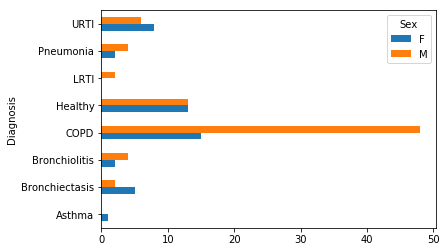

In [7]:
patient_info.groupby(['Diagnosis','Sex'
                      ]).Patient_number.count().unstack().plot.barh()

In [8]:
healthy_group = patient_info.loc[patient_info['Diagnosis'] == 'Healthy']
COPD_group = patient_info.loc[patient_info['Diagnosis'] == 'COPD']
URTI_group = patient_info.loc[patient_info['Diagnosis'] == 'URTI']

In [9]:
def plot_hist_group(var_name):
    plt.hist(healthy_group[var_name].dropna(),
             alpha=0.5,
             label='Healthy',
             density=True,
             color='g')
    plt.hist(COPD_group[var_name].dropna(),
             alpha=0.5,
             label='COPD',
             density=True,
             color='b')
    plt.hist(URTI_group[var_name].dropna(),
             alpha=0.5,
             label='URTI',
             density=True,
             color='r')
    plt.legend(loc='upper right')
    plt.xlabel(var_name)
    plt.ylabel('Density')
    plt.xticks(np.arange(0, 100, step=10))
    plt.show()

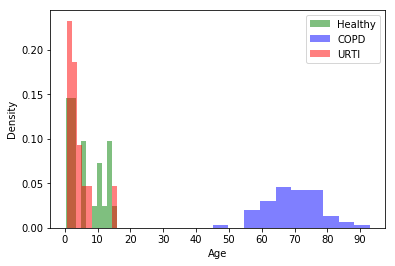

In [10]:
plot_hist_group('Age')

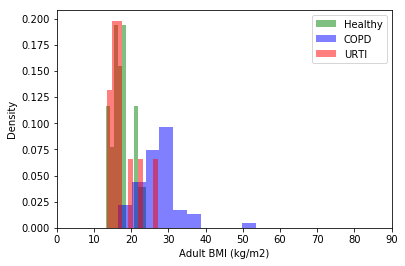

In [11]:
plot_hist_group('Adult BMI (kg/m2)')

In [12]:
def get_info_from_filename(root):

    sound_file_list = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

    sound_file_infor = pd.DataFrame(sound_file_list, columns = ['tmp_name'])

    sound_file_infor = sound_file_infor['tmp_name'].str.split(
                    '_', expand=True)

    sound_file_infor.columns = [
        'Patient_number', 'Recording_index', 'Chest_location', 'Acquisition_mode',
        'Recording_equipment'
    ]
    return sound_file_infor

In [13]:
filename_info = get_info_from_filename(
    '../Downloads/respiratory-sound-database/Respiratory_Sound_Database/audio_and_txt_files/'
).sort_values(by = 'Patient_number')

In [14]:
patient_info['Patient_number'] = patient_info['Patient_number'].astype(str)

filename_info['Patient_number'] = filename_info['Patient_number'].astype(str)

patient_info_and_filename = pd.merge(patient_info,
                                     filename_info,
                                     on='Patient_number',
                                     how='outer')
patient_info_and_filename['audio_file_name'] = patient_info_and_filename[
    'Patient_number'] + '_' + patient_info_and_filename[
        'Recording_index'] + '_' + patient_info_and_filename[
            'Chest_location'] + '_' + patient_info_and_filename[
                'Acquisition_mode'] + '_' + patient_info_and_filename[
                    'Recording_equipment']

In [15]:
healthy_group = patient_info_and_filename.loc[patient_info_and_filename['Diagnosis'] == 'Healthy']
COPD_group = patient_info_and_filename.loc[patient_info_and_filename['Diagnosis'] == 'COPD']
URTI_group = patient_info_and_filename.loc[patient_info_and_filename['Diagnosis'] == 'URTI']

In [16]:
 patient_info_and_filename

,Patient_number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm),Diagnosis,Recording_index,Chest_location,Acquisition_mode,Recording_equipment,audio_file_name
0,101,3.00,F,19.385777,19.0,99.0,URTI,1b1,Al,sc,Meditron,101_1b1_Al_sc_Meditron
1,101,3.00,F,19.385777,19.0,99.0,URTI,1b1,Pr,sc,Meditron,101_1b1_Pr_sc_Meditron
2,102,0.75,F,18.389942,9.8,73.0,Healthy,1b1,Ar,sc,Meditron,102_1b1_Ar_sc_Meditron
3,103,70.00,F,33.000000,NaN,NaN,Asthma,2b2,Ar,mc,LittC2SE,103_2b2_Ar_mc_LittC2SE
4,104,70.00,F,28.470000,NaN,NaN,COPD,1b1,Pr,sc,Litt3200,104_1b1_Pr_sc_Litt3200
5,104,70.00,F,28.470000,NaN,NaN,COPD,1b1,Ll,sc,Litt3200,104_1b1_Ll_sc_Litt3200
6,104,70.00,F,28.470000,NaN,NaN,COPD,1b1,Pl,sc,Litt3200,104_1b1_Pl_sc_Litt3200
7,104,70.00,F,28.470000,NaN,NaN,COPD,1b1,Lr,sc,Litt3200,104_1b1_Lr_sc_Litt3200
8,104,70.00,F,28.470000,NaN,NaN,COPD,1b1,Ar,sc,Litt3200,104_1b1_Ar_sc_Litt3200
9,104,70.00,F,28.470000,NaN,NaN,COPD,1b1,Al,sc,Litt3200,104_1b1_Al_sc_Litt3200


## count wheeze and crackles

In [29]:
rec_annotations_dict = {}
path = '../Downloads/respiratory-sound-database/Respiratory_Sound_Database/audio_and_txt_files/'
for i in range(0, patient_info_and_filename.shape[0]):
    filename = patient_info_and_filename.loc[i, 'audio_file_name']
    rec_annotations_dict[filename] = pd.read_csv(path + filename + '.txt',
                                          header=None,
                                          sep='\t')


In [32]:
rec_annotations_dict['101_1b1_Al_sc_Meditron']

,0,1,2,3,sum,none,both
0,0.036,0.579,0,0,0,True,False
1,0.579,2.450,0,0,0,True,False
2,2.450,3.893,0,0,0,True,False
3,3.893,5.793,0,0,0,True,False
4,5.793,7.521,0,0,0,True,False
5,7.521,9.279,0,0,0,True,False
6,9.279,11.150,0,0,0,True,False
7,11.150,13.036,0,0,0,True,False
8,13.036,14.721,0,0,0,True,False
9,14.721,16.707,0,0,0,True,False


In [35]:
crackles = 0
wheezes = 0
both = 0
normal = 0

for key in rec_annotations_dict:
    rec_annotations_dict[key][
        'sum'] = rec_annotations_dict[key][2] + rec_annotations_dict[key][3]
    rec_annotations_dict[key].apply(lambda x: x.a if (x.a == x.b) or ((x.a == 'fruit') and (
        x.b == 'both')) else 'Unkonwn',
             axis=1)
    rec_annotations_dict[key]['crackles'] = (
        rec_annotations_dict[key]['sum'] == 1 & rec_annotations_dict[key][2] ==
        1)
    rec_annotations_dict[key]['wheezes'] = (rec_annotations_dict[key]['sum'] ==
                                            1 & rec_annotations_dict[key][3] ==
                                            1)
    rec_annotations_dict[key]['none'] = (rec_annotations_dict[key]['sum'] == 0)
    rec_annotations_dict[key]['both'] = (rec_annotations_dict[key]['sum'] == 2)
    #print(rec_annotations_dict[key])
    crackles += rec_annotations_dict[key]['crackles'].sum()
    wheezes += rec_annotations_dict[key]['wheezes'].sum()
    normal += rec_annotations_dict[key]['none'].sum()
    both += rec_annotations_dict[key]['both'].sum()
print(crackles, wheezes, both, normal)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [42]:
no_label_list = []
crack_list = []
wheeze_list = []
both_sym_list = []
filename_list = []
for key in rec_annotations_dict:
    d = rec_annotations_dict[key]
    no_labels = len(d[(d[2] == 0) & (d[3] == 0)].index)
    n_crackles = len(d[(d[2] == 1) & (d[3] == 0)].index)
    n_wheezes = len(d[(d[2] == 0) & (d[3] == 1)].index)
    both_sym = len(d[(d[2] == 1) & (d[3] == 1)].index)
    no_label_list.append(no_labels)
    crack_list.append(n_crackles)
    wheeze_list.append(n_wheezes)
    both_sym_list.append(both_sym)
    filename_list.append(f)

In [40]:
file_label_df = pd.DataFrame(
    data={
        'filename': filename_list,
        'no label': no_label_list,
        'crackles only': crack_list,
        'wheezes only': wheeze_list,
        'crackles and wheezees': both_sym_list
    })

In [41]:
w_labels = file_label_df[(file_label_df['crackles only'] != 0) | (file_label_df['wheezes only'] != 0) | (file_label_df['crackles and wheezees'] != 0)]
file_label_df.sum()

no label                 3642
crackles only            1864
wheezes only              886
crackles and wheezees     506
dtype: int64

## baseline

In [541]:
x = 3642+1864+886
1/x*(3642*3642/x + 1864*1864/x + 886*886/x)

0.42889520066541253

# Plot sound waves

In [3]:
import librosa
def display_mel_spectogram(y, sr):
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

    # Convert to log scale (dB)
    log_S = librosa.power_to_db(S, ref=np.max)

    # Make a new figure
    plt.figure(figsize=(12,4))

    # Display the spectrogram on a mel scale
    # sample rate and hop length parameters are used to render the time axis
    librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

    # draw a color bar
    plt.colorbar(format='%+02.0f dB')

    # Make the figure layout compact
    plt.tight_layout()


## plot healthy subject

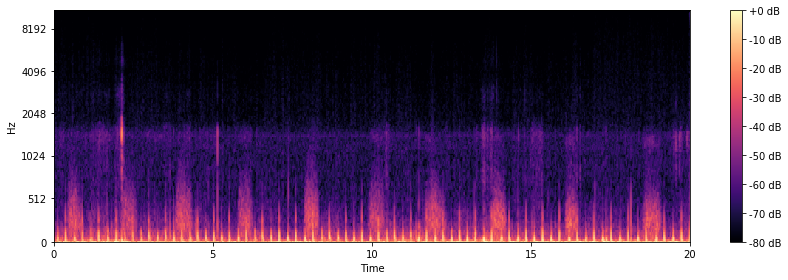

In [8]:
healthy_y, healthy_sr = lib.load(
    '../Downloads/respiratory-sound-database/Respiratory_Sound_Database/audio_and_txt_files/126_1b1_Al_sc_Meditron.wav',
)
display_mel_spectogram(healthy_y, healthy_sr)
savefig

In [628]:
healthy_sr

22050

## plot COPD patient

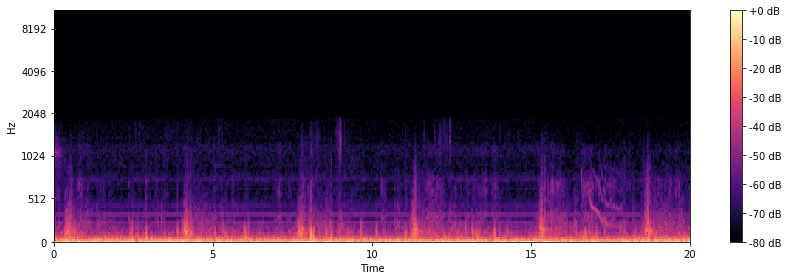

In [211]:
COPD_y, COPD_sr = lib.load(
    '../Downloads/respiratory-sound-database/Respiratory_Sound_Database/audio_and_txt_files/218_1b1_Al_sc_Meditron.wav'
)
display_mel_spectogram(COPD_y[0:20 * sr], COPD_sr)

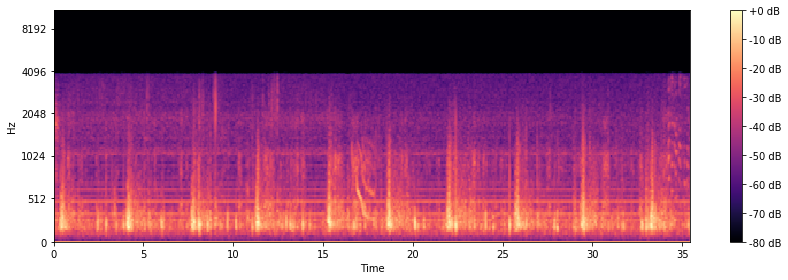

In [556]:
display_mel_spectogram(preprocessing(COPD_y[0:int(35.4450*sr)], COPD_sr), 8000)

In [474]:
COPD_y, COPD_sr = lib.load(
    '../Downloads/respiratory-sound-database/Respiratory_Sound_Database/audio_and_txt_files/218_1b1_Al_sc_Meditron.wav'
)
audio_info = pd.read_csv('../Downloads/respiratory-sound-database/Respiratory_Sound_Database/audio_and_txt_files/218_1b1_Al_sc_Meditron.txt',
                             header=None,
                             sep='\t')
audio_info.columns = ['Start', 'End', 'Crackles', 'Wheezes']
print(audio_info)

       Start      End  Crackles  Wheezes
0    0.28649   3.8505         0        0
1    3.85050   7.5061         0        0
2    7.50610  11.1620         0        0
3   11.16200  15.0920         0        0
4   15.09200  18.4840         0        1
5   18.48400  21.6240         1        0
6   21.62400  25.5670         1        0
7   25.56700  29.1880         1        0
8   29.18800  35.4450         1        0
9   35.44500  40.4300         1        1
10  40.43000  45.2540         1        1
11  45.25400  50.3880         1        1
12  50.38800  57.5960         1        1
13  57.59600  65.2280         0        0
14  65.22800  71.0500         1        1


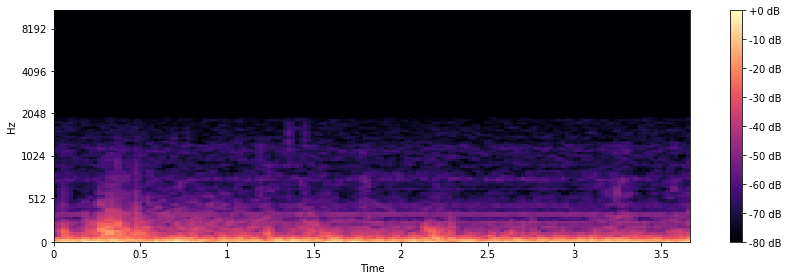

In [494]:
#normal
display_mel_spectogram(COPD_y[int(3.85050*sr):int(7.5061*sr)], COPD_sr)

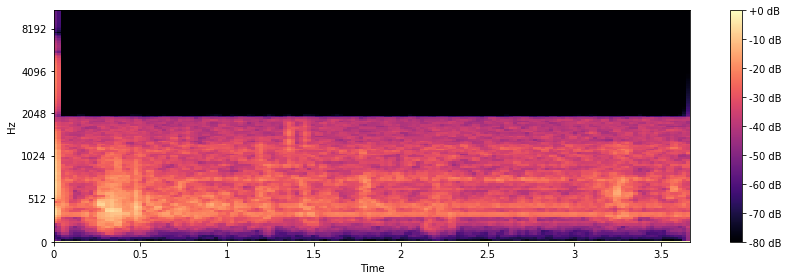

In [555]:
#normal
display_mel_spectogram(
    preprocessing(COPD_y[int(3.85050 * sr):int(7.5061 * sr)], 8000),
    COPD_sr)

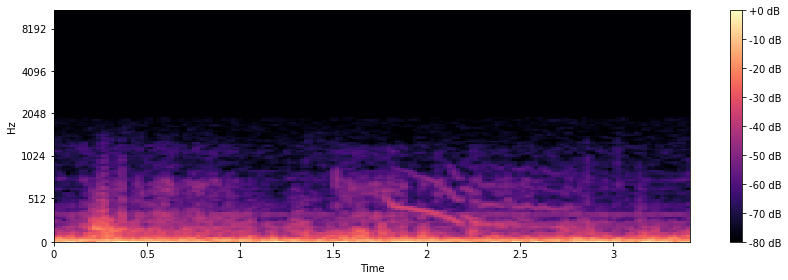

In [477]:
#wheezes
test = display_mel_spectogram(COPD_y[int(15.09200*sr):int(18.4840*sr)], COPD_sr)

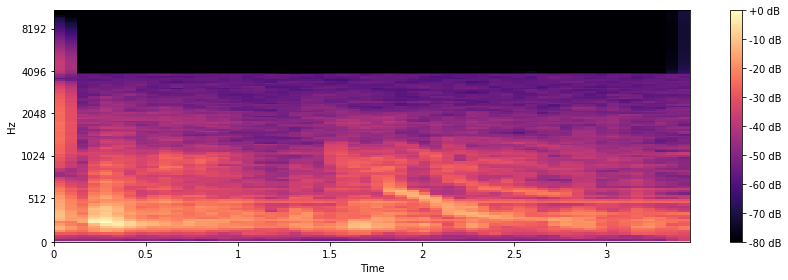

In [557]:
#wheezes
display_mel_spectogram(
    preprocessing(COPD_y[int(15.09200*sr):int(18.4840*sr)], COPD_sr),
    8000)

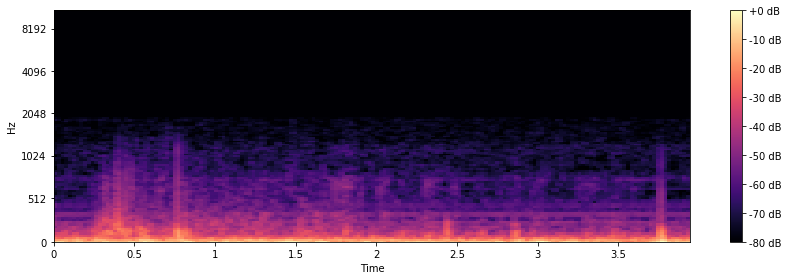

In [479]:
#crackles
display_mel_spectogram(COPD_y[int(21.62400*sr):int(25.5670*sr)], COPD_sr)

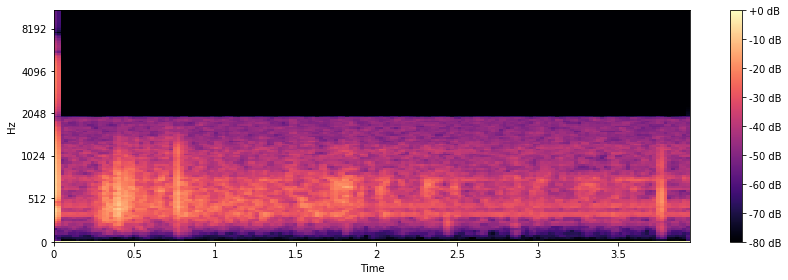

In [558]:
#crackles
display_mel_spectogram(
    preprocessing(COPD_y[int(21.62400*sr):int(25.5670*sr)], 8000),
    COPD_sr)

# Audio preprocessing

In [1]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, ProgbarLogger
from keras.utils import np_utils
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import itertools
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Bandpass filter
Band-pass filter was used to filter out sounds
below 150 Hz since these might have contained heart sounds, and DC offsets; 
and to prevent aliasing on frequencies above 2000 Hz.

In [206]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

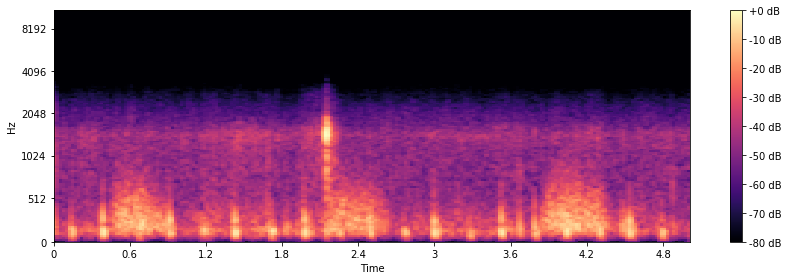

In [275]:
signal_healthy = butter_bandpass_filter(healthy_y[0:5*sr], 150, 2000, healthy_sr)
display_mel_spectogram(signal_healthy, healthy_sr)

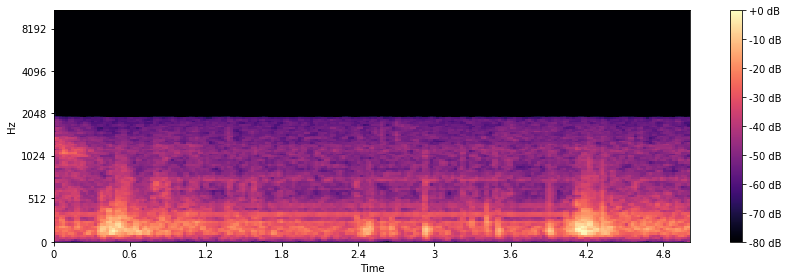

In [276]:
signal_COPD = butter_bandpass_filter(COPD_y[0:5*sr], 150, 2000, COPD_sr)
display_mel_spectogram(signal_COPD, COPD_sr)

## Resample signal
All events collected were then resampled to 8000 Hz, as information on the respiratory sounds is bandlimited up to 2000 Hz only

NameError: name 'fig' is not defined

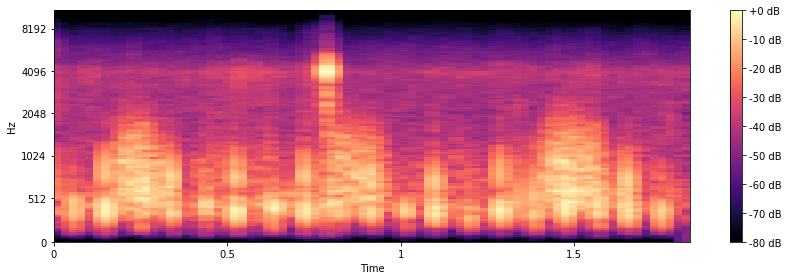

In [277]:
healthy_y_8k = lib.core.resample(signal_healthy, healthy_sr, 8000)
Fig = display_mel_spectogram(healthy_y_8k, healthy_sr)
fig.savefig('test.png')

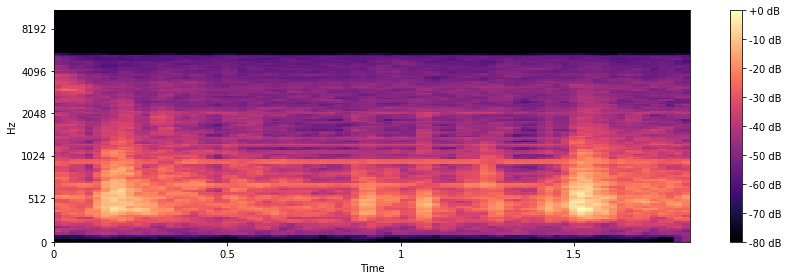

In [274]:
COPD_y_8k = lib.core.resample(signal_COPD, COPD_sr, 8000)
display_mel_spectogram(COPD_y_8k, COPD_sr)

## Amplitude scaling

In [222]:
def amplitude_scaling(y, a, b):
    y = a + (b-a)*(y - np.min(y))/(np.max(y) - np.min(y))
    return y
amplitude_scaling(healthy_y_8k, -1, 1)

array([0.06922793, 0.0492897 , 0.05508006, ..., 0.43276536, 0.42599022,
       0.4850099 ], dtype=float32)

In [262]:
def preprocessing(y, sr):
    y = butter_bandpass_filter(y, 150, 2000, sr)
    y_8k = lib.core.resample(y, sr, 8000)
    y_amp = amplitude_scaling(y_8k, -1, 1)
    return y_amp

In [263]:
preprocessing(healthy_y, healthy_sr)

array([-0.00273213, -0.00668975, -0.02891437, ..., -0.0507463 ,
       -0.04991305, -0.0550023 ])

# Feature engineering

## MFCC

In [283]:
from PIL import Image
COPD_mfcc = librosa.feature.mfcc(COPD_y, COPD_sr, n_mfcc=40)
healthy_mfcc = librosa.feature.mfcc(preprocessing(healthy_y, healthy_sr),
                                    healthy_sr,
                                    n_mfcc=40)
librosa.display.specshow(COPD_mfcc).convert('LA')
plt.savefig('test')

ModuleNotFoundError: No module named 'PIL'

In [266]:
librosa.feature.mfcc(preprocessing(healthy_y, healthy_sr), healthy_sr, n_mfcc = 40).shape

(40, 313)

## MFCC with repeated padding

In [473]:
a = np.array([[1,2,3,4],[2,3,4,5]])
np.pad(a,(0, 7), 'wrap')

array([[1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3],
       [2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4],
       [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3],
       [2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4],
       [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3],
       [2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4],
       [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3],
       [2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4],
       [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3]])

## linear predictive coding

In [267]:
%%bash
pip3 install audiolazy

In [451]:
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import utilities
from scipy.signal import lfilter

ImportError: failed to find libmagic.  Check your installation

In [446]:
ncoeff=2+fs/1000
a=lpc(x,ncoeff)

In [452]:
import audiolazy


In [454]:
y.shape

(441000,)

# Segment audios

## Check segment length

101_1b1_Al_sc_Meditron
101_1b1_Pr_sc_Meditron
102_1b1_Ar_sc_Meditron
103_2b2_Ar_mc_LittC2SE
104_1b1_Pr_sc_Litt3200
104_1b1_Ll_sc_Litt3200
104_1b1_Pl_sc_Litt3200
104_1b1_Lr_sc_Litt3200
104_1b1_Ar_sc_Litt3200
104_1b1_Al_sc_Litt3200
105_1b1_Tc_sc_Meditron
106_2b1_Pl_mc_LittC2SE
106_2b1_Pr_mc_LittC2SE
107_2b3_Pl_mc_AKGC417L
107_2b5_Lr_mc_AKGC417L
107_3p2_Al_mc_AKGC417L
107_2b4_Ar_mc_AKGC417L
107_2b5_Al_mc_AKGC417L
107_2b3_Lr_mc_AKGC417L
107_2b5_Pl_mc_AKGC417L
107_3p2_Ll_mc_AKGC417L
107_2b4_Ll_mc_AKGC417L
107_2b3_Tc_mc_AKGC417L
107_2b4_Lr_mc_AKGC417L
107_2b5_Tc_mc_AKGC417L
107_2b3_Al_mc_AKGC417L
107_2b5_Ll_mc_AKGC417L
107_2b4_Al_mc_AKGC417L
107_2b4_Tc_mc_AKGC417L
107_3p2_Tc_mc_AKGC417L
107_2b3_Pr_mc_AKGC417L
107_3p2_Ar_mc_AKGC417L
107_2b3_Ar_mc_AKGC417L
107_2b5_Pr_mc_AKGC417L
107_3p2_Pl_mc_AKGC417L
107_2b5_Ar_mc_AKGC417L
107_2b4_Pl_mc_AKGC417L
107_3p2_Lr_mc_AKGC417L
107_2b4_Pr_mc_AKGC417L
107_3p2_Pr_mc_AKGC417L
107_2b3_Ll_mc_AKGC417L
108_1b1_Al_sc_Meditron
109_1b1_Ar_sc_Litt3200
109_1b1_Lr_

154_2b4_Al_mc_AKGC417L
154_3b3_Ll_mc_AKGC417L
154_2b4_Lr_mc_AKGC417L
154_4b4_Ll_mc_AKGC417L
155_2b1_Al_mc_LittC2SE
156_5b3_Pl_mc_AKGC417L
156_2b3_Al_mc_AKGC417L
156_5b3_Pr_mc_AKGC417L
156_2b3_Pr_mc_AKGC417L
156_2b3_Lr_mc_AKGC417L
156_2b3_Ll_mc_AKGC417L
156_5b3_Lr_mc_AKGC417L
156_8b3_Ar_mc_AKGC417L
156_5b3_Al_mc_AKGC417L
156_8b3_Ll_mc_AKGC417L
156_5b3_Ll_mc_AKGC417L
156_2b3_Ar_mc_AKGC417L
156_8b3_Pl_mc_AKGC417L
156_8b3_Al_mc_AKGC417L
156_2b3_Pl_mc_AKGC417L
156_5b3_Ar_mc_AKGC417L
156_8b3_Lr_mc_AKGC417L
157_1b1_Lr_sc_Meditron
157_1b1_Al_sc_Meditron
157_1b1_Pl_sc_Meditron
157_1b1_Ar_sc_Meditron
157_1b1_Pr_sc_Meditron
158_1p3_Ar_mc_AKGC417L
158_1p3_Ll_mc_AKGC417L
158_1p4_Pl_mc_AKGC417L
158_1p2_Ll_mc_AKGC417L
158_2p3_Lr_mc_AKGC417L
158_1p2_Pr_mc_AKGC417L
158_1p3_Tc_mc_AKGC417L
158_1p3_Lr_mc_AKGC417L
158_1p2_Tc_mc_AKGC417L
158_1p4_Tc_mc_AKGC417L
158_2p2_Ar_mc_AKGC417L
158_1p2_Ar_mc_AKGC417L
158_1p4_Lr_mc_AKGC417L
158_1p4_Pr_mc_AKGC417L
158_2p3_Tc_mc_AKGC417L
158_1p2_Pl_mc_AKGC417L
158_1p3_Al_

195_1b1_Pr_sc_Litt3200
195_1b1_Ll_sc_Litt3200
196_1b1_Pr_sc_Meditron
197_1b1_Al_sc_Meditron
197_1b1_Tc_sc_Meditron
198_6p1_Ll_mc_AKGC417L
198_6p1_Pr_mc_AKGC417L
198_1b5_Tc_mc_AKGC417L
198_6p1_Lr_mc_AKGC417L
198_1b5_Al_mc_AKGC417L
198_1b5_Pl_mc_AKGC417L
198_6p1_Tc_mc_AKGC417L
198_1b5_Lr_mc_AKGC417L
198_1b5_Ll_mc_AKGC417L
198_1b5_Pr_mc_AKGC417L
198_6p1_Al_mc_AKGC417L
198_6p1_Ar_mc_AKGC417L
198_6p1_Pl_mc_AKGC417L
198_1b5_Ar_mc_AKGC417L
199_2b3_Ll_mc_LittC2SE
199_2b1_Ll_mc_LittC2SE
200_2p4_Ar_mc_AKGC417L
200_2p2_Al_mc_AKGC417L
200_2p3_Tc_mc_AKGC417L
200_2p4_Pr_mc_AKGC417L
200_2p4_Lr_mc_AKGC417L
200_2p2_Ar_mc_AKGC417L
200_2p3_Al_mc_AKGC417L
200_2p3_Pl_mc_AKGC417L
200_2p3_Pr_mc_AKGC417L
200_3p4_Al_mc_AKGC417L
200_2p4_Tc_mc_AKGC417L
200_2p2_Pl_mc_AKGC417L
200_3p4_Pr_mc_AKGC417L
200_2p4_Pl_mc_AKGC417L
200_3p4_Pl_mc_AKGC417L
200_2p2_Tc_mc_AKGC417L
200_2p4_Al_mc_AKGC417L
200_3p4_Ar_mc_AKGC417L
200_2p2_Pr_mc_AKGC417L
200_2p3_Ar_mc_AKGC417L
200_3p4_Tc_mc_AKGC417L
200_2p2_Lr_mc_AKGC417L
200_2p3_Lr_

(array([1.470e+03, 3.759e+03, 1.434e+03, 1.720e+02, 5.100e+01, 9.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.2   ,  1.7963,  3.3926,  4.9889,  6.5852,  8.1815,  9.7778,
        11.3741, 12.9704, 14.5667, 16.163 ]),
 <a list of 10 Patch objects>)

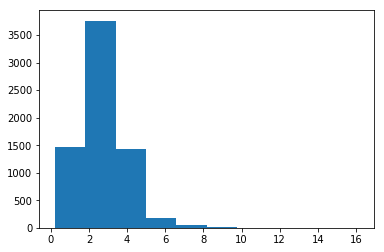

In [99]:
segment_length = []
for i in range(0, patient_info_and_filename.shape[0]):
    audio_file_name = patient_info_and_filename.loc[i, 'audio_file_name']
    print(audio_file_name)
    audio_path = '../Downloads/respiratory-sound-database/Respiratory_Sound_Database/audio_and_txt_files/' + audio_file_name + '.wav'
    #whole_audio = (np.load(path + 'audio_and_txt_files/' +
    #                       df.loc[i, 'audio_file_name'] + '_wav.npy'))

    y, sr = lib.load(audio_path)
    audio_info = pd.read_csv(path + audio_file_name + '.txt',
                             header=None,
                             sep='\t')
    audio_info.columns = ['Start', 'End', 'Crackles', 'Wheezes']
    #print(audio_info)
    
    for j in range(0, audio_info.shape[0]):
        start = float(audio_info.loc[j, 'Start'])
        stop = float(audio_info.loc[j, 'End'])
        segment_length.append(stop - start)
plt.hist(segment_length)

(array([1.470e+03, 3.759e+03, 1.434e+03, 1.720e+02, 5.100e+01, 9.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.2   ,  1.7963,  3.3926,  4.9889,  6.5852,  8.1815,  9.7778,
        11.3741, 12.9704, 14.5667, 16.163 ]),
 <a list of 10 Patch objects>)

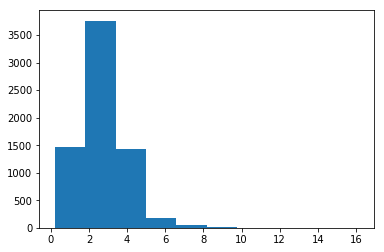

In [100]:
plt.hist(segment_length)

In [102]:
(np.array(segment_length) <= 5).sum() / len(segment_length)

0.9662220933603943

## Segment audio data and extract MFCC averaged

In [301]:
#crackles_feature = np.zeros((1864, 128, 215))
crackles_feature = []
crackles_label = []
#wheezes_feature = np.zeros((886, 128, 215))
wheezes_feature = []
wheezes_label = []
#both_feature = np.zeros((506, 128, 215))
both_feature = []
both_label = []
#normal_feature = np.zeros((3642, 128, 215))
normal_feature = []
normal_label = []
# crackles_cnt = 0
# wheezes_cnt = 0
# both_cnt = 0
# normal_cnt = 0
audio_feature_length = []
path = '../Downloads/respiratory-sound-database/Respiratory_Sound_Database/audio_and_txt_files/'
for i in range(0, patient_info_and_filename.shape[0]):
    audio_file_name = patient_info_and_filename.loc[i, 'audio_file_name']
    print(audio_file_name)
    audio_path = '../Downloads/respiratory-sound-database/Respiratory_Sound_Database/audio_and_txt_files/' + audio_file_name + '.wav'
    #whole_audio = (np.load(path + 'audio_and_txt_files/' +
    #                       df.loc[i, 'audio_file_name'] + '_wav.npy'))

    y, sr = lib.load(audio_path)
    audio_info = pd.read_csv(path + audio_file_name + '.txt',
                             header=None,
                             sep='\t')
    audio_info.columns = ['Start', 'End', 'Crackles', 'Wheezes']
    #print(audio_info)

    for j in range(0, audio_info.shape[0]):
        start = int(float(audio_info.loc[j, 'Start']) * sr)
        stop = int(float(audio_info.loc[j, 'End']) * sr)
        #sound_length = (stop - start)/sr
        #print(sound_length)
        segment_audio = y[start:stop]
        segment_audio = preprocessing(segment_audio, sr)
        #features = lib.feature.melspectrogram(segment_audio,
        #                                      sr=sr,
        #                                      n_mels=128)
        features = lib.feature.mfcc(segment_audio, sr=sr,  n_mfcc=13)
        mfcc_13 = np.mean(features, axis = 1)
        #print(features.shape[1])
        #print(all_features[cnt,:,0:np.array(features).shape[1]].shape)

        #audio_feature_length.append(features.shape[1])

        if audio_info.loc[j, 'Crackles'] == 0 and audio_info.loc[
                j, 'Wheezes'] == 0:
            label = 0
            normal_label.append(label)
            normal_feature.append(mfcc_13)
            
#             if np.array(features).shape[1] <= 215:
#                 normal_feature[normal_cnt, :, 0:np.array(features).
#                                shape[1]] = np.array(features)
#             if np.array(features).shape[1] > 215:
#                 normal_feature[normal_cnt, :, :] = np.array(features)[:, 0:215]
#             normal_label.append(label)
#             normal_cnt += 1
        if audio_info.loc[j, 'Crackles'] == 1 and audio_info.loc[
                j, 'Wheezes'] == 0:
            label = 1
            crackles_label.append(label)
            crackles_feature.append(mfcc_13)
            
#             if np.array(features).shape[1] <= 215:
#                 crackles_feature[crackles_cnt, :, 0:np.array(features).
#                                shape[1]] = np.array(features)
#             if np.array(features).shape[1] > 215:
#                 crackles_feature[crackles_cnt, :, :] = np.array(features)[:, 0:215]
#             crackles_label.append(label)
#             crackles_cnt += 1
            
        if audio_info.loc[j, 'Crackles'] == 0 and audio_info.loc[
                j, 'Wheezes'] == 1:
            label = 2
            wheezes_label.append(label)
            wheezes_feature.append(mfcc_13)
#             if np.array(features).shape[1] <= 215:
#                 wheezes_feature[wheezes_cnt, :, 0:np.array(features).
#                                shape[1]] = np.array(features)
#             if np.array(features).shape[1] > 215:
#                 wheezes_feature[wheezes_cnt, :, :] = np.array(features)[:, 0:215]
#             wheezes_label.append(label)
#             wheezes_cnt += 1
            
        if audio_info.loc[j, 'Crackles'] == 1 and audio_info.loc[
                j, 'Wheezes'] == 1:
            label = 3
            both_label.append(label)
            both_feature.append(mfcc_13)
#             if np.array(features).shape[1] <= 215:
#                 both_feature[both_cnt, :, 0:np.array(features).
#                                shape[1]] = np.array(features)
#             if np.array(features).shape[1] > 215:
#                 both_feature[both_cnt, :, :] = np.array(features)[:, 0:215]
#             both_label.append(label)
#             both_cnt += 1

        #print(label)


101_1b1_Al_sc_Meditron
101_1b1_Pr_sc_Meditron
102_1b1_Ar_sc_Meditron
103_2b2_Ar_mc_LittC2SE
104_1b1_Pr_sc_Litt3200
104_1b1_Ll_sc_Litt3200
104_1b1_Pl_sc_Litt3200
104_1b1_Lr_sc_Litt3200
104_1b1_Ar_sc_Litt3200
104_1b1_Al_sc_Litt3200
105_1b1_Tc_sc_Meditron
106_2b1_Pl_mc_LittC2SE
106_2b1_Pr_mc_LittC2SE
107_2b3_Pl_mc_AKGC417L
107_2b5_Lr_mc_AKGC417L
107_3p2_Al_mc_AKGC417L
107_2b4_Ar_mc_AKGC417L
107_2b5_Al_mc_AKGC417L
107_2b3_Lr_mc_AKGC417L
107_2b5_Pl_mc_AKGC417L
107_3p2_Ll_mc_AKGC417L
107_2b4_Ll_mc_AKGC417L
107_2b3_Tc_mc_AKGC417L
107_2b4_Lr_mc_AKGC417L
107_2b5_Tc_mc_AKGC417L
107_2b3_Al_mc_AKGC417L
107_2b5_Ll_mc_AKGC417L
107_2b4_Al_mc_AKGC417L
107_2b4_Tc_mc_AKGC417L
107_3p2_Tc_mc_AKGC417L
107_2b3_Pr_mc_AKGC417L
107_3p2_Ar_mc_AKGC417L
107_2b3_Ar_mc_AKGC417L
107_2b5_Pr_mc_AKGC417L
107_3p2_Pl_mc_AKGC417L
107_2b5_Ar_mc_AKGC417L
107_2b4_Pl_mc_AKGC417L
107_3p2_Lr_mc_AKGC417L
107_2b4_Pr_mc_AKGC417L
107_3p2_Pr_mc_AKGC417L
107_2b3_Ll_mc_AKGC417L
108_1b1_Al_sc_Meditron
109_1b1_Ar_sc_Litt3200
109_1b1_Lr_

154_2b4_Al_mc_AKGC417L
154_3b3_Ll_mc_AKGC417L
154_2b4_Lr_mc_AKGC417L
154_4b4_Ll_mc_AKGC417L
155_2b1_Al_mc_LittC2SE
156_5b3_Pl_mc_AKGC417L
156_2b3_Al_mc_AKGC417L
156_5b3_Pr_mc_AKGC417L
156_2b3_Pr_mc_AKGC417L
156_2b3_Lr_mc_AKGC417L
156_2b3_Ll_mc_AKGC417L
156_5b3_Lr_mc_AKGC417L
156_8b3_Ar_mc_AKGC417L
156_5b3_Al_mc_AKGC417L
156_8b3_Ll_mc_AKGC417L
156_5b3_Ll_mc_AKGC417L
156_2b3_Ar_mc_AKGC417L
156_8b3_Pl_mc_AKGC417L
156_8b3_Al_mc_AKGC417L
156_2b3_Pl_mc_AKGC417L
156_5b3_Ar_mc_AKGC417L
156_8b3_Lr_mc_AKGC417L
157_1b1_Lr_sc_Meditron
157_1b1_Al_sc_Meditron
157_1b1_Pl_sc_Meditron
157_1b1_Ar_sc_Meditron
157_1b1_Pr_sc_Meditron
158_1p3_Ar_mc_AKGC417L
158_1p3_Ll_mc_AKGC417L
158_1p4_Pl_mc_AKGC417L
158_1p2_Ll_mc_AKGC417L
158_2p3_Lr_mc_AKGC417L
158_1p2_Pr_mc_AKGC417L
158_1p3_Tc_mc_AKGC417L
158_1p3_Lr_mc_AKGC417L
158_1p2_Tc_mc_AKGC417L
158_1p4_Tc_mc_AKGC417L
158_2p2_Ar_mc_AKGC417L
158_1p2_Ar_mc_AKGC417L
158_1p4_Lr_mc_AKGC417L
158_1p4_Pr_mc_AKGC417L
158_2p3_Tc_mc_AKGC417L
158_1p2_Pl_mc_AKGC417L
158_1p3_Al_

195_1b1_Pr_sc_Litt3200
195_1b1_Ll_sc_Litt3200
196_1b1_Pr_sc_Meditron
197_1b1_Al_sc_Meditron
197_1b1_Tc_sc_Meditron
198_6p1_Ll_mc_AKGC417L
198_6p1_Pr_mc_AKGC417L
198_1b5_Tc_mc_AKGC417L
198_6p1_Lr_mc_AKGC417L
198_1b5_Al_mc_AKGC417L
198_1b5_Pl_mc_AKGC417L
198_6p1_Tc_mc_AKGC417L
198_1b5_Lr_mc_AKGC417L
198_1b5_Ll_mc_AKGC417L
198_1b5_Pr_mc_AKGC417L
198_6p1_Al_mc_AKGC417L
198_6p1_Ar_mc_AKGC417L
198_6p1_Pl_mc_AKGC417L
198_1b5_Ar_mc_AKGC417L
199_2b3_Ll_mc_LittC2SE
199_2b1_Ll_mc_LittC2SE
200_2p4_Ar_mc_AKGC417L
200_2p2_Al_mc_AKGC417L
200_2p3_Tc_mc_AKGC417L
200_2p4_Pr_mc_AKGC417L
200_2p4_Lr_mc_AKGC417L
200_2p2_Ar_mc_AKGC417L
200_2p3_Al_mc_AKGC417L
200_2p3_Pl_mc_AKGC417L
200_2p3_Pr_mc_AKGC417L
200_3p4_Al_mc_AKGC417L
200_2p4_Tc_mc_AKGC417L
200_2p2_Pl_mc_AKGC417L
200_3p4_Pr_mc_AKGC417L
200_2p4_Pl_mc_AKGC417L
200_3p4_Pl_mc_AKGC417L
200_2p2_Tc_mc_AKGC417L
200_2p4_Al_mc_AKGC417L
200_3p4_Ar_mc_AKGC417L
200_2p2_Pr_mc_AKGC417L
200_2p3_Ar_mc_AKGC417L
200_3p4_Tc_mc_AKGC417L
200_2p2_Lr_mc_AKGC417L
200_2p3_Lr_

## Segment audio data and extract MFCC

In [349]:
crackles_feature_mfcc = np.zeros((1864, 60, 13))
#crackles_feature = []
crackles_label = []
wheezes_feature_mfcc = np.zeros((886, 60, 13))
#wheezes_feature = []
wheezes_label = []
both_feature_mfcc = np.zeros((506, 60, 13))
#both_feature = []
both_label = []
normal_feature_mfcc = np.zeros((3642, 60, 13))
#normal_feature = []
normal_label = []
crackles_cnt = 0
wheezes_cnt = 0
both_cnt = 0
normal_cnt = 0
audio_feature_length = []
path = '../Downloads/respiratory-sound-database/Respiratory_Sound_Database/audio_and_txt_files/'
for i in range(0, patient_info_and_filename.shape[0]):
    audio_file_name = patient_info_and_filename.loc[i, 'audio_file_name']
    print(audio_file_name)
    audio_path = '../Downloads/respiratory-sound-database/Respiratory_Sound_Database/audio_and_txt_files/' + audio_file_name + '.wav'
    #whole_audio = (np.load(path + 'audio_and_txt_files/' +
    #                       df.loc[i, 'audio_file_name'] + '_wav.npy'))

    y, sr = lib.load(audio_path)
    audio_info = pd.read_csv(path + audio_file_name + '.txt',
                             header=None,
                             sep='\t')
    audio_info.columns = ['Start', 'End', 'Crackles', 'Wheezes']
    #print(audio_info)

    for j in range(0, audio_info.shape[0]):
        start = int(float(audio_info.loc[j, 'Start']) * sr)
        stop = int(float(audio_info.loc[j, 'End']) * sr)
        #sound_length = (stop - start)/sr
        #print(sound_length)
        segment_audio = y[start:stop]
        segment_audio = preprocessing(segment_audio, sr)
        #features = lib.feature.melspectrogram(segment_audio,
        #                                      sr=sr,
        #                                      n_mels=128)
        features = lib.feature.mfcc(segment_audio, sr=sr,
                                    n_mfcc=13).transpose()
        #mfcc_13 = np.mean(features, axis = 1)
        #print(features.shape)
        #print(all_features[cnt,:,0:np.array(features).shape[1]].shape)

        audio_feature_length.append(features)

        if audio_info.loc[j, 'Crackles'] == 0 and audio_info.loc[
                j, 'Wheezes'] == 0:
            label = 0
            #normal_label.append(label)
            #normal_feature.append(mfcc_13)

            if np.array(features).shape[0] <= 60:
                normal_feature_mfcc[normal_cnt, 0:np.array(features).
                                    shape[0], :] = np.array(features)
            if np.array(features).shape[0] > 60:
                normal_feature_mfcc[normal_cnt, :, :] = np.array(
                    features)[0:60, :]
            normal_label.append(label)
            normal_cnt += 1
        if audio_info.loc[j, 'Crackles'] == 1 and audio_info.loc[
                j, 'Wheezes'] == 0:
            label = 1
            #crackles_label.append(label)
            #crackles_feature.append(mfcc_13)

            if np.array(features).shape[0] <= 60:
                crackles_feature_mfcc[crackles_cnt, 0:np.array(features).
                                    shape[0], :] = np.array(features)
            if np.array(features).shape[0] > 60:
                crackles_feature_mfcc[crackles_cnt, :, :] = np.array(
                    features)[0:60, :]
            crackles_label.append(label)
            crackles_cnt += 1

        if audio_info.loc[j, 'Crackles'] == 0 and audio_info.loc[
                j, 'Wheezes'] == 1:
            label = 2
            #wheezes_label.append(label)
            #wheezes_feature.append(mfcc_13)
            if np.array(features).shape[0] <= 60:
                wheezes_feature_mfcc[wheezes_cnt, 0:np.array(features).
                                    shape[0], :] = np.array(features)
            if np.array(features).shape[0] > 60:
                wheezes_feature_mfcc[wheezes_cnt, :, :] = np.array(
                    features)[0:60, :]
            wheezes_label.append(label)
            wheezes_cnt += 1

        if audio_info.loc[j, 'Crackles'] == 1 and audio_info.loc[
                j, 'Wheezes'] == 1:
            label = 3
            #both_label.append(label)
            #both_feature.append(mfcc_13)
            if np.array(features).shape[0] <= 60:
                both_feature_mfcc[both_cnt, 0:np.array(features).
                                    shape[0], :] = np.array(features)
            if np.array(features).shape[0] > 60:
                both_feature_mfcc[both_cnt, :, :] = np.array(
                    features)[0:60, :]
            both_label.append(label)
            both_cnt += 1

        #print(label)

101_1b1_Al_sc_Meditron
101_1b1_Pr_sc_Meditron
102_1b1_Ar_sc_Meditron
103_2b2_Ar_mc_LittC2SE
104_1b1_Pr_sc_Litt3200
104_1b1_Ll_sc_Litt3200
104_1b1_Pl_sc_Litt3200
104_1b1_Lr_sc_Litt3200
104_1b1_Ar_sc_Litt3200
104_1b1_Al_sc_Litt3200
105_1b1_Tc_sc_Meditron
106_2b1_Pl_mc_LittC2SE
106_2b1_Pr_mc_LittC2SE
107_2b3_Pl_mc_AKGC417L
107_2b5_Lr_mc_AKGC417L
107_3p2_Al_mc_AKGC417L
107_2b4_Ar_mc_AKGC417L
107_2b5_Al_mc_AKGC417L
107_2b3_Lr_mc_AKGC417L
107_2b5_Pl_mc_AKGC417L
107_3p2_Ll_mc_AKGC417L
107_2b4_Ll_mc_AKGC417L
107_2b3_Tc_mc_AKGC417L
107_2b4_Lr_mc_AKGC417L
107_2b5_Tc_mc_AKGC417L
107_2b3_Al_mc_AKGC417L
107_2b5_Ll_mc_AKGC417L
107_2b4_Al_mc_AKGC417L
107_2b4_Tc_mc_AKGC417L
107_3p2_Tc_mc_AKGC417L
107_2b3_Pr_mc_AKGC417L
107_3p2_Ar_mc_AKGC417L
107_2b3_Ar_mc_AKGC417L
107_2b5_Pr_mc_AKGC417L
107_3p2_Pl_mc_AKGC417L
107_2b5_Ar_mc_AKGC417L
107_2b4_Pl_mc_AKGC417L
107_3p2_Lr_mc_AKGC417L
107_2b4_Pr_mc_AKGC417L
107_3p2_Pr_mc_AKGC417L
107_2b3_Ll_mc_AKGC417L
108_1b1_Al_sc_Meditron
109_1b1_Ar_sc_Litt3200
109_1b1_Lr_

154_2b4_Al_mc_AKGC417L
154_3b3_Ll_mc_AKGC417L
154_2b4_Lr_mc_AKGC417L
154_4b4_Ll_mc_AKGC417L
155_2b1_Al_mc_LittC2SE
156_5b3_Pl_mc_AKGC417L
156_2b3_Al_mc_AKGC417L
156_5b3_Pr_mc_AKGC417L
156_2b3_Pr_mc_AKGC417L
156_2b3_Lr_mc_AKGC417L
156_2b3_Ll_mc_AKGC417L
156_5b3_Lr_mc_AKGC417L
156_8b3_Ar_mc_AKGC417L
156_5b3_Al_mc_AKGC417L
156_8b3_Ll_mc_AKGC417L
156_5b3_Ll_mc_AKGC417L
156_2b3_Ar_mc_AKGC417L
156_8b3_Pl_mc_AKGC417L
156_8b3_Al_mc_AKGC417L
156_2b3_Pl_mc_AKGC417L
156_5b3_Ar_mc_AKGC417L
156_8b3_Lr_mc_AKGC417L
157_1b1_Lr_sc_Meditron
157_1b1_Al_sc_Meditron
157_1b1_Pl_sc_Meditron
157_1b1_Ar_sc_Meditron
157_1b1_Pr_sc_Meditron
158_1p3_Ar_mc_AKGC417L
158_1p3_Ll_mc_AKGC417L
158_1p4_Pl_mc_AKGC417L
158_1p2_Ll_mc_AKGC417L
158_2p3_Lr_mc_AKGC417L
158_1p2_Pr_mc_AKGC417L
158_1p3_Tc_mc_AKGC417L
158_1p3_Lr_mc_AKGC417L
158_1p2_Tc_mc_AKGC417L
158_1p4_Tc_mc_AKGC417L
158_2p2_Ar_mc_AKGC417L
158_1p2_Ar_mc_AKGC417L
158_1p4_Lr_mc_AKGC417L
158_1p4_Pr_mc_AKGC417L
158_2p3_Tc_mc_AKGC417L
158_1p2_Pl_mc_AKGC417L
158_1p3_Al_

195_1b1_Pr_sc_Litt3200
195_1b1_Ll_sc_Litt3200
196_1b1_Pr_sc_Meditron
197_1b1_Al_sc_Meditron
197_1b1_Tc_sc_Meditron
198_6p1_Ll_mc_AKGC417L
198_6p1_Pr_mc_AKGC417L
198_1b5_Tc_mc_AKGC417L
198_6p1_Lr_mc_AKGC417L
198_1b5_Al_mc_AKGC417L
198_1b5_Pl_mc_AKGC417L
198_6p1_Tc_mc_AKGC417L
198_1b5_Lr_mc_AKGC417L
198_1b5_Ll_mc_AKGC417L
198_1b5_Pr_mc_AKGC417L
198_6p1_Al_mc_AKGC417L
198_6p1_Ar_mc_AKGC417L
198_6p1_Pl_mc_AKGC417L
198_1b5_Ar_mc_AKGC417L
199_2b3_Ll_mc_LittC2SE
199_2b1_Ll_mc_LittC2SE
200_2p4_Ar_mc_AKGC417L
200_2p2_Al_mc_AKGC417L
200_2p3_Tc_mc_AKGC417L
200_2p4_Pr_mc_AKGC417L
200_2p4_Lr_mc_AKGC417L
200_2p2_Ar_mc_AKGC417L
200_2p3_Al_mc_AKGC417L
200_2p3_Pl_mc_AKGC417L
200_2p3_Pr_mc_AKGC417L
200_3p4_Al_mc_AKGC417L
200_2p4_Tc_mc_AKGC417L
200_2p2_Pl_mc_AKGC417L
200_3p4_Pr_mc_AKGC417L
200_2p4_Pl_mc_AKGC417L
200_3p4_Pl_mc_AKGC417L
200_2p2_Tc_mc_AKGC417L
200_2p4_Al_mc_AKGC417L
200_3p4_Ar_mc_AKGC417L
200_2p2_Pr_mc_AKGC417L
200_2p3_Ar_mc_AKGC417L
200_3p4_Tc_mc_AKGC417L
200_2p2_Lr_mc_AKGC417L
200_2p3_Lr_

In [444]:
x_train_crackles, x_test_crackles, x_val_crackles, y_train_crackles, y_test_crackles, y_val_crackles = data_split(crackles_feature_mfcc, crackles_label)
x_train_wheezes, x_test_wheezes, x_val_wheezes, y_train_wheezes, y_test_wheezes, y_val_wheezes = data_split(wheezes_feature_mfcc, wheezes_label)
#x_train_both, x_test_both, x_val_both, y_train_both, y_test_both, y_val_both = data_split(both_feature_mfcc, both_label)
x_train_normal, x_test_normal, x_val_normal, y_train_normal, y_test_normal, y_val_normal = data_split(normal_feature_mfcc, normal_label)
x_train = np.concatenate(
    (x_train_crackles, x_train_wheezes, x_train_normal), axis = 0)
x_test = np.concatenate(
    (x_test_crackles, x_test_wheezes, x_test_normal), axis = 0)
x_val = np.concatenate(
    (x_val_crackles, x_val_wheezes, x_val_normal), axis = 0)
y_train = np.concatenate(
    (y_train_crackles, y_train_wheezes, y_train_normal), axis = 0)
y_test = np.concatenate(
    (y_test_crackles, y_test_wheezes, y_test_normal), axis = 0)
y_val = np.concatenate(
    (y_val_crackles, y_val_wheezes, y_val_normal), axis = 0)
# np.save('x_train_noboth.npy', x_train)
# np.save('y_train_noboth.npy', y_train)
# np.save('x_test_noboth.npy', x_test)
# np.save('y_test_noboth.npy', y_test)
# np.save('x_val_noboth.npy', x_val)
# np.save('y_val_noboth.npy', y_val)


## Segment audio data and extract MFCC with repeated padding

In [499]:
crackles_feature_mfcc_rep = np.zeros((1864, 60, 13))
#crackles_feature = []
crackles_label = []
wheezes_feature_mfcc_rep = np.zeros((886, 60, 13))
#wheezes_feature = []
wheezes_label = []
both_feature_mfcc_rep = np.zeros((506, 60, 13))
#both_feature = []
both_label = []
normal_feature_mfcc_rep = np.zeros((3642, 60, 13))
#normal_feature = []
normal_label = []
crackles_cnt = 0
wheezes_cnt = 0
both_cnt = 0
normal_cnt = 0
audio_feature_length = []
path = '../Downloads/respiratory-sound-database/Respiratory_Sound_Database/audio_and_txt_files/'
for i in range(0, patient_info_and_filename.shape[0]):
    audio_file_name = patient_info_and_filename.loc[i, 'audio_file_name']
    print(audio_file_name)
    audio_path = '../Downloads/respiratory-sound-database/Respiratory_Sound_Database/audio_and_txt_files/' + audio_file_name + '.wav'
    #whole_audio = (np.load(path + 'audio_and_txt_files/' +
    #                       df.loc[i, 'audio_file_name'] + '_wav.npy'))

    y, sr = lib.load(audio_path)
    audio_info = pd.read_csv(path + audio_file_name + '.txt',
                             header=None,
                             sep='\t')
    audio_info.columns = ['Start', 'End', 'Crackles', 'Wheezes']
    #print(audio_info)

    for j in range(0, audio_info.shape[0]):
        start = int(float(audio_info.loc[j, 'Start']) * sr)
        stop = int(float(audio_info.loc[j, 'End']) * sr)
        #sound_length = (stop - start)/sr
        #print(sound_length)
        segment_audio = y[start:stop]
        segment_audio = preprocessing(segment_audio, sr)
        #features = lib.feature.melspectrogram(segment_audio,
        #                                      sr=sr,
        #                                      n_mels=128)
        features = lib.feature.mfcc(segment_audio, sr=sr,
                                    n_mfcc=13).transpose()
        #mfcc_13 = np.mean(features, axis = 1)
        #print(features.shape)
        #print(all_features[cnt,:,0:np.array(features).shape[1]].shape)

        #audio_feature_length.append(features)

        if audio_info.loc[j, 'Crackles'] == 0 and audio_info.loc[
                j, 'Wheezes'] == 0:
            label = 0
            #normal_label.append(label)
            #normal_feature.append(mfcc_13)

            if np.array(features).shape[0] <= 60:
                normal_feature_mfcc_rep[normal_cnt, :, :] = np.pad(
                    np.array(features),
                    ([0, 60 - np.array(features).shape[0]], [0, 0]), 'wrap')
                
        
            if np.array(features).shape[0] > 60:
                normal_feature_mfcc_rep[normal_cnt, :, :] = np.array(
                    features)[0:60, :]
            normal_label.append(label)
            normal_cnt += 1
        if audio_info.loc[j, 'Crackles'] == 1 and audio_info.loc[
                j, 'Wheezes'] == 0:
            label = 1
            #crackles_label.append(label)
            #crackles_feature.append(mfcc_13)

            if np.array(features).shape[0] <= 60:
                crackles_feature_mfcc_rep[crackles_cnt, :, :] = np.pad(
                    np.array(features),
                    ([0, 60 - np.array(features).shape[0]], [0, 0]), 'wrap')
            if np.array(features).shape[0] > 60:
                crackles_feature_mfcc_rep[crackles_cnt, :, :] = np.array(
                    features)[0:60, :]
            crackles_label.append(label)
            crackles_cnt += 1

        if audio_info.loc[j, 'Crackles'] == 0 and audio_info.loc[
                j, 'Wheezes'] == 1:
            label = 2
            #wheezes_label.append(label)
            #wheezes_feature.append(mfcc_13)
            if np.array(features).shape[0] <= 60:
                wheezes_feature_mfcc_rep[wheezes_cnt, :, :] = np.pad(
                    np.array(features),
                    ([0, 60 - np.array(features).shape[0]], [0, 0]), 'wrap')
            if np.array(features).shape[0] > 60:
                wheezes_feature_mfcc_rep[wheezes_cnt, :, :] = np.array(
                    features)[0:60, :]
            wheezes_label.append(label)
            wheezes_cnt += 1

        if audio_info.loc[j, 'Crackles'] == 1 and audio_info.loc[
                j, 'Wheezes'] == 1:
            label = 3
            #both_label.append(label)
            #both_feature.append(mfcc_13)
            if np.array(features).shape[0] <= 60:
                both_feature_mfcc_rep[both_cnt, :, :] = np.pad(
                    np.array(features),
                    ([0, 60 - np.array(features).shape[0]], [0, 0]), 'wrap')
            if np.array(features).shape[0] > 60:
                both_feature_mfcc_rep[both_cnt, :, :] = np.array(features)[0:60, :]
            both_label.append(label)
            both_cnt += 1

 

101_1b1_Al_sc_Meditron
101_1b1_Pr_sc_Meditron
102_1b1_Ar_sc_Meditron
103_2b2_Ar_mc_LittC2SE
104_1b1_Pr_sc_Litt3200
104_1b1_Ll_sc_Litt3200
104_1b1_Pl_sc_Litt3200
104_1b1_Lr_sc_Litt3200
104_1b1_Ar_sc_Litt3200
104_1b1_Al_sc_Litt3200
105_1b1_Tc_sc_Meditron
106_2b1_Pl_mc_LittC2SE
106_2b1_Pr_mc_LittC2SE
107_2b3_Pl_mc_AKGC417L
107_2b5_Lr_mc_AKGC417L
107_3p2_Al_mc_AKGC417L
107_2b4_Ar_mc_AKGC417L
107_2b5_Al_mc_AKGC417L
107_2b3_Lr_mc_AKGC417L
107_2b5_Pl_mc_AKGC417L
107_3p2_Ll_mc_AKGC417L
107_2b4_Ll_mc_AKGC417L
107_2b3_Tc_mc_AKGC417L
107_2b4_Lr_mc_AKGC417L
107_2b5_Tc_mc_AKGC417L
107_2b3_Al_mc_AKGC417L
107_2b5_Ll_mc_AKGC417L
107_2b4_Al_mc_AKGC417L
107_2b4_Tc_mc_AKGC417L
107_3p2_Tc_mc_AKGC417L
107_2b3_Pr_mc_AKGC417L
107_3p2_Ar_mc_AKGC417L
107_2b3_Ar_mc_AKGC417L
107_2b5_Pr_mc_AKGC417L
107_3p2_Pl_mc_AKGC417L
107_2b5_Ar_mc_AKGC417L
107_2b4_Pl_mc_AKGC417L
107_3p2_Lr_mc_AKGC417L
107_2b4_Pr_mc_AKGC417L
107_3p2_Pr_mc_AKGC417L
107_2b3_Ll_mc_AKGC417L
108_1b1_Al_sc_Meditron
109_1b1_Ar_sc_Litt3200
109_1b1_Lr_

154_2b4_Al_mc_AKGC417L
154_3b3_Ll_mc_AKGC417L
154_2b4_Lr_mc_AKGC417L
154_4b4_Ll_mc_AKGC417L
155_2b1_Al_mc_LittC2SE
156_5b3_Pl_mc_AKGC417L
156_2b3_Al_mc_AKGC417L
156_5b3_Pr_mc_AKGC417L
156_2b3_Pr_mc_AKGC417L
156_2b3_Lr_mc_AKGC417L
156_2b3_Ll_mc_AKGC417L
156_5b3_Lr_mc_AKGC417L
156_8b3_Ar_mc_AKGC417L
156_5b3_Al_mc_AKGC417L
156_8b3_Ll_mc_AKGC417L
156_5b3_Ll_mc_AKGC417L
156_2b3_Ar_mc_AKGC417L
156_8b3_Pl_mc_AKGC417L
156_8b3_Al_mc_AKGC417L
156_2b3_Pl_mc_AKGC417L
156_5b3_Ar_mc_AKGC417L
156_8b3_Lr_mc_AKGC417L
157_1b1_Lr_sc_Meditron
157_1b1_Al_sc_Meditron
157_1b1_Pl_sc_Meditron
157_1b1_Ar_sc_Meditron
157_1b1_Pr_sc_Meditron
158_1p3_Ar_mc_AKGC417L
158_1p3_Ll_mc_AKGC417L
158_1p4_Pl_mc_AKGC417L
158_1p2_Ll_mc_AKGC417L
158_2p3_Lr_mc_AKGC417L
158_1p2_Pr_mc_AKGC417L
158_1p3_Tc_mc_AKGC417L
158_1p3_Lr_mc_AKGC417L
158_1p2_Tc_mc_AKGC417L
158_1p4_Tc_mc_AKGC417L
158_2p2_Ar_mc_AKGC417L
158_1p2_Ar_mc_AKGC417L
158_1p4_Lr_mc_AKGC417L
158_1p4_Pr_mc_AKGC417L
158_2p3_Tc_mc_AKGC417L
158_1p2_Pl_mc_AKGC417L
158_1p3_Al_

195_1b1_Pr_sc_Litt3200
195_1b1_Ll_sc_Litt3200
196_1b1_Pr_sc_Meditron
197_1b1_Al_sc_Meditron
197_1b1_Tc_sc_Meditron
198_6p1_Ll_mc_AKGC417L
198_6p1_Pr_mc_AKGC417L
198_1b5_Tc_mc_AKGC417L
198_6p1_Lr_mc_AKGC417L
198_1b5_Al_mc_AKGC417L
198_1b5_Pl_mc_AKGC417L
198_6p1_Tc_mc_AKGC417L
198_1b5_Lr_mc_AKGC417L
198_1b5_Ll_mc_AKGC417L
198_1b5_Pr_mc_AKGC417L
198_6p1_Al_mc_AKGC417L
198_6p1_Ar_mc_AKGC417L
198_6p1_Pl_mc_AKGC417L
198_1b5_Ar_mc_AKGC417L
199_2b3_Ll_mc_LittC2SE
199_2b1_Ll_mc_LittC2SE
200_2p4_Ar_mc_AKGC417L
200_2p2_Al_mc_AKGC417L
200_2p3_Tc_mc_AKGC417L
200_2p4_Pr_mc_AKGC417L
200_2p4_Lr_mc_AKGC417L
200_2p2_Ar_mc_AKGC417L
200_2p3_Al_mc_AKGC417L
200_2p3_Pl_mc_AKGC417L
200_2p3_Pr_mc_AKGC417L
200_3p4_Al_mc_AKGC417L
200_2p4_Tc_mc_AKGC417L
200_2p2_Pl_mc_AKGC417L
200_3p4_Pr_mc_AKGC417L
200_2p4_Pl_mc_AKGC417L
200_3p4_Pl_mc_AKGC417L
200_2p2_Tc_mc_AKGC417L
200_2p4_Al_mc_AKGC417L
200_3p4_Ar_mc_AKGC417L
200_2p2_Pr_mc_AKGC417L
200_2p3_Ar_mc_AKGC417L
200_3p4_Tc_mc_AKGC417L
200_2p2_Lr_mc_AKGC417L
200_2p3_Lr_

In [500]:
x_train_crackles, x_test_crackles, x_val_crackles, y_train_crackles, y_test_crackles, y_val_crackles = data_split(crackles_feature_mfcc_rep, crackles_label)
x_train_wheezes, x_test_wheezes, x_val_wheezes, y_train_wheezes, y_test_wheezes, y_val_wheezes = data_split(wheezes_feature_mfcc_rep, wheezes_label)
#x_train_both, x_test_both, x_val_both, y_train_both, y_test_both, y_val_both = data_split(both_feature_mfcc, both_label)
x_train_normal, x_test_normal, x_val_normal, y_train_normal, y_test_normal, y_val_normal = data_split(normal_feature_mfcc_rep, normal_label)
x_train = np.concatenate(
    (x_train_crackles, x_train_wheezes, x_train_normal), axis = 0)
x_test = np.concatenate(
    (x_test_crackles, x_test_wheezes, x_test_normal), axis = 0)
x_val = np.concatenate(
    (x_val_crackles, x_val_wheezes, x_val_normal), axis = 0)
y_train = np.concatenate(
    (y_train_crackles, y_train_wheezes, y_train_normal), axis = 0)
y_test = np.concatenate(
    (y_test_crackles, y_test_wheezes, y_test_normal), axis = 0)
y_val = np.concatenate(
    (y_val_crackles, y_val_wheezes, y_val_normal), axis = 0)
np.save('x_train_noboth_rep.npy', x_train)
np.save('y_train_noboth_rep.npy', y_train)
np.save('x_test_noboth_rep.npy', x_test)
np.save('y_test_noboth_rep.npy', y_test)
np.save('x_val_noboth_rep.npy', x_val)
np.save('y_val_noboth_rep.npy', y_val)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## MFCC 20

In [586]:
crackles_feature_mfcc20 = np.zeros((1864, 60, 20))
#crackles_feature = []
crackles_label = []
wheezes_feature_mfcc20 = np.zeros((886, 60, 20))
#wheezes_feature = []
wheezes_label = []
both_feature_mfcc20 = np.zeros((506, 60, 20))
#both_feature = []
both_label = []
normal_feature_mfcc20 = np.zeros((3642, 60, 20))
#normal_feature = []
normal_label = []
crackles_cnt = 0
wheezes_cnt = 0
both_cnt = 0
normal_cnt = 0
audio_feature_length = []
path = '../Downloads/respiratory-sound-database/Respiratory_Sound_Database/audio_and_txt_files/'
for i in range(0, patient_info_and_filename.shape[0]):
    audio_file_name = patient_info_and_filename.loc[i, 'audio_file_name']
    print(audio_file_name)
    audio_path = '../Downloads/respiratory-sound-database/Respiratory_Sound_Database/audio_and_txt_files/' + audio_file_name + '.wav'
    #whole_audio = (np.load(path + 'audio_and_txt_files/' +
    #                       df.loc[i, 'audio_file_name'] + '_wav.npy'))

    y, sr = lib.load(audio_path)
    audio_info = pd.read_csv(path + audio_file_name + '.txt',
                             header=None,
                             sep='\t')
    audio_info.columns = ['Start', 'End', 'Crackles', 'Wheezes']
    #print(audio_info)

    for j in range(0, audio_info.shape[0]):
        start = int(float(audio_info.loc[j, 'Start']) * sr)
        stop = int(float(audio_info.loc[j, 'End']) * sr)
        #sound_length = (stop - start)/sr
        #print(sound_length)
        segment_audio = y[start:stop]
        segment_audio = preprocessing(segment_audio, sr)
        #features = lib.feature.melspectrogram(segment_audio,
        #                                      sr=sr,
        #                                      n_mels=128)
        features = lib.feature.mfcc(segment_audio, sr=sr,
                                    n_mfcc=20).transpose()
        #mfcc_13 = np.mean(features, axis = 1)
        #print(features.shape)
        #print(all_features[cnt,:,0:np.array(features).shape[1]].shape)

        audio_feature_length.append(features)

        if audio_info.loc[j, 'Crackles'] == 0 and audio_info.loc[
                j, 'Wheezes'] == 0:
            label = 0
            #normal_label.append(label)
            #normal_feature.append(mfcc_13)

            if np.array(features).shape[0] <= 60:
                normal_feature_mfcc20[normal_cnt, 0:np.array(features).
                                    shape[0], :] = np.array(features)
            if np.array(features).shape[0] > 60:
                normal_feature_mfcc20[normal_cnt, :, :] = np.array(
                    features)[0:60, :]
            normal_label.append(label)
            normal_cnt += 1
        if audio_info.loc[j, 'Crackles'] == 1 and audio_info.loc[
                j, 'Wheezes'] == 0:
            label = 1
            #crackles_label.append(label)
            #crackles_feature.append(mfcc_13)

            if np.array(features).shape[0] <= 60:
                crackles_feature_mfcc20[crackles_cnt, 0:np.array(features).
                                    shape[0], :] = np.array(features)
            if np.array(features).shape[0] > 60:
                crackles_feature_mfcc20[crackles_cnt, :, :] = np.array(
                    features)[0:60, :]
            crackles_label.append(label)
            crackles_cnt += 1

        if audio_info.loc[j, 'Crackles'] == 0 and audio_info.loc[
                j, 'Wheezes'] == 1:
            label = 2
            #wheezes_label.append(label)
            #wheezes_feature.append(mfcc_13)
            if np.array(features).shape[0] <= 60:
                wheezes_feature_mfcc20[wheezes_cnt, 0:np.array(features).
                                    shape[0], :] = np.array(features)
            if np.array(features).shape[0] > 60:
                wheezes_feature_mfcc20[wheezes_cnt, :, :] = np.array(
                    features)[0:60, :]
            wheezes_label.append(label)
            wheezes_cnt += 1

        if audio_info.loc[j, 'Crackles'] == 1 and audio_info.loc[
                j, 'Wheezes'] == 1:
            label = 3
            #both_label.append(label)
            #both_feature.append(mfcc_13)
            if np.array(features).shape[0] <= 60:
                both_feature_mfcc20[both_cnt, 0:np.array(features).
                                    shape[0], :] = np.array(features)
            if np.array(features).shape[0] > 60:
                both_feature_mfcc20[both_cnt, :, :] = np.array(
                    features)[0:60, :]
            both_label.append(label)
            both_cnt += 1

        #print(label)

101_1b1_Al_sc_Meditron
101_1b1_Pr_sc_Meditron
102_1b1_Ar_sc_Meditron
103_2b2_Ar_mc_LittC2SE
104_1b1_Pr_sc_Litt3200
104_1b1_Ll_sc_Litt3200
104_1b1_Pl_sc_Litt3200
104_1b1_Lr_sc_Litt3200
104_1b1_Ar_sc_Litt3200
104_1b1_Al_sc_Litt3200
105_1b1_Tc_sc_Meditron
106_2b1_Pl_mc_LittC2SE
106_2b1_Pr_mc_LittC2SE
107_2b3_Pl_mc_AKGC417L
107_2b5_Lr_mc_AKGC417L
107_3p2_Al_mc_AKGC417L
107_2b4_Ar_mc_AKGC417L
107_2b5_Al_mc_AKGC417L
107_2b3_Lr_mc_AKGC417L
107_2b5_Pl_mc_AKGC417L
107_3p2_Ll_mc_AKGC417L
107_2b4_Ll_mc_AKGC417L
107_2b3_Tc_mc_AKGC417L
107_2b4_Lr_mc_AKGC417L
107_2b5_Tc_mc_AKGC417L
107_2b3_Al_mc_AKGC417L
107_2b5_Ll_mc_AKGC417L
107_2b4_Al_mc_AKGC417L
107_2b4_Tc_mc_AKGC417L
107_3p2_Tc_mc_AKGC417L
107_2b3_Pr_mc_AKGC417L
107_3p2_Ar_mc_AKGC417L
107_2b3_Ar_mc_AKGC417L
107_2b5_Pr_mc_AKGC417L
107_3p2_Pl_mc_AKGC417L
107_2b5_Ar_mc_AKGC417L
107_2b4_Pl_mc_AKGC417L
107_3p2_Lr_mc_AKGC417L
107_2b4_Pr_mc_AKGC417L
107_3p2_Pr_mc_AKGC417L
107_2b3_Ll_mc_AKGC417L
108_1b1_Al_sc_Meditron
109_1b1_Ar_sc_Litt3200
109_1b1_Lr_

154_2b4_Al_mc_AKGC417L
154_3b3_Ll_mc_AKGC417L
154_2b4_Lr_mc_AKGC417L
154_4b4_Ll_mc_AKGC417L
155_2b1_Al_mc_LittC2SE
156_5b3_Pl_mc_AKGC417L
156_2b3_Al_mc_AKGC417L
156_5b3_Pr_mc_AKGC417L
156_2b3_Pr_mc_AKGC417L
156_2b3_Lr_mc_AKGC417L
156_2b3_Ll_mc_AKGC417L
156_5b3_Lr_mc_AKGC417L
156_8b3_Ar_mc_AKGC417L
156_5b3_Al_mc_AKGC417L
156_8b3_Ll_mc_AKGC417L
156_5b3_Ll_mc_AKGC417L
156_2b3_Ar_mc_AKGC417L
156_8b3_Pl_mc_AKGC417L
156_8b3_Al_mc_AKGC417L
156_2b3_Pl_mc_AKGC417L
156_5b3_Ar_mc_AKGC417L
156_8b3_Lr_mc_AKGC417L
157_1b1_Lr_sc_Meditron
157_1b1_Al_sc_Meditron
157_1b1_Pl_sc_Meditron
157_1b1_Ar_sc_Meditron
157_1b1_Pr_sc_Meditron
158_1p3_Ar_mc_AKGC417L
158_1p3_Ll_mc_AKGC417L
158_1p4_Pl_mc_AKGC417L
158_1p2_Ll_mc_AKGC417L
158_2p3_Lr_mc_AKGC417L
158_1p2_Pr_mc_AKGC417L
158_1p3_Tc_mc_AKGC417L
158_1p3_Lr_mc_AKGC417L
158_1p2_Tc_mc_AKGC417L
158_1p4_Tc_mc_AKGC417L
158_2p2_Ar_mc_AKGC417L
158_1p2_Ar_mc_AKGC417L
158_1p4_Lr_mc_AKGC417L
158_1p4_Pr_mc_AKGC417L
158_2p3_Tc_mc_AKGC417L
158_1p2_Pl_mc_AKGC417L
158_1p3_Al_

195_1b1_Pr_sc_Litt3200
195_1b1_Ll_sc_Litt3200
196_1b1_Pr_sc_Meditron
197_1b1_Al_sc_Meditron
197_1b1_Tc_sc_Meditron
198_6p1_Ll_mc_AKGC417L
198_6p1_Pr_mc_AKGC417L
198_1b5_Tc_mc_AKGC417L
198_6p1_Lr_mc_AKGC417L
198_1b5_Al_mc_AKGC417L
198_1b5_Pl_mc_AKGC417L
198_6p1_Tc_mc_AKGC417L
198_1b5_Lr_mc_AKGC417L
198_1b5_Ll_mc_AKGC417L
198_1b5_Pr_mc_AKGC417L
198_6p1_Al_mc_AKGC417L
198_6p1_Ar_mc_AKGC417L
198_6p1_Pl_mc_AKGC417L
198_1b5_Ar_mc_AKGC417L
199_2b3_Ll_mc_LittC2SE
199_2b1_Ll_mc_LittC2SE
200_2p4_Ar_mc_AKGC417L
200_2p2_Al_mc_AKGC417L
200_2p3_Tc_mc_AKGC417L
200_2p4_Pr_mc_AKGC417L
200_2p4_Lr_mc_AKGC417L
200_2p2_Ar_mc_AKGC417L
200_2p3_Al_mc_AKGC417L
200_2p3_Pl_mc_AKGC417L
200_2p3_Pr_mc_AKGC417L
200_3p4_Al_mc_AKGC417L
200_2p4_Tc_mc_AKGC417L
200_2p2_Pl_mc_AKGC417L
200_3p4_Pr_mc_AKGC417L
200_2p4_Pl_mc_AKGC417L
200_3p4_Pl_mc_AKGC417L
200_2p2_Tc_mc_AKGC417L
200_2p4_Al_mc_AKGC417L
200_3p4_Ar_mc_AKGC417L
200_2p2_Pr_mc_AKGC417L
200_2p3_Ar_mc_AKGC417L
200_3p4_Tc_mc_AKGC417L
200_2p2_Lr_mc_AKGC417L
200_2p3_Lr_

In [587]:
x_train_crackles, x_test_crackles, x_val_crackles, y_train_crackles, y_test_crackles, y_val_crackles = data_split(crackles_feature_mfcc20, crackles_label)
x_train_wheezes, x_test_wheezes, x_val_wheezes, y_train_wheezes, y_test_wheezes, y_val_wheezes = data_split(wheezes_feature_mfcc20, wheezes_label)
#x_train_both, x_test_both, x_val_both, y_train_both, y_test_both, y_val_both = data_split(both_feature_mfcc, both_label)
x_train_normal, x_test_normal, x_val_normal, y_train_normal, y_test_normal, y_val_normal = data_split(normal_feature_mfcc20, normal_label)
x_train = np.concatenate(
    (x_train_crackles, x_train_wheezes, x_train_normal), axis = 0)
x_test = np.concatenate(
    (x_test_crackles, x_test_wheezes, x_test_normal), axis = 0)
x_val = np.concatenate(
    (x_val_crackles, x_val_wheezes, x_val_normal), axis = 0)
y_train = np.concatenate(
    (y_train_crackles, y_train_wheezes, y_train_normal), axis = 0)
y_test = np.concatenate(
    (y_test_crackles, y_test_wheezes, y_test_normal), axis = 0)
y_val = np.concatenate(
    (y_val_crackles, y_val_wheezes, y_val_normal), axis = 0)
np.save('x_train_mfcc20_zeros.npy', x_train)
np.save('y_train_mfcc20_zeros.npy', y_train)
np.save('x_test_mfcc20_zeros.npy', x_test)
np.save('y_test_mfcc20_zeros.npy', y_test)
np.save('x_val_mfcc20_zeros.npy', x_val)
np.save('y_val_mfcc20_zeros.npy', y_val)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Classification

## PCA

In [440]:
np.array(crackles_feature).shape

(0,)

In [438]:

x_data = np.concatenate((crackles_feature, wheezes_feature, normal_feature),
                        axis=0)
y_data = np.concatenate((crackles_label, wheezes_label, normal_label), axis=0)
x_data = pd.DataFrame(x_data,
                      columns=[
                          'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5',
                          'MFCC_6', 'MFCC_7', 'MFCC_8', 'MFCC_9', 'MFCC_10',
                          'MFCC_11', 'MFCC_12', 'MFCC_13'
                      ])
y_data = pd.DataFrame(y_data, columns=['target'])
y_data['target'][y_data['target'] == 0] = 'Normal'
y_data['target'][y_data['target'] == 1] = 'Crackles'
y_data['target'][y_data['target'] == 2] = 'Wheezes'

ValueError: Empty data passed with indices specified.

In [437]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
x_data = StandardScaler().fit_transform(x_data)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_data)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, y_data], axis = 1)


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

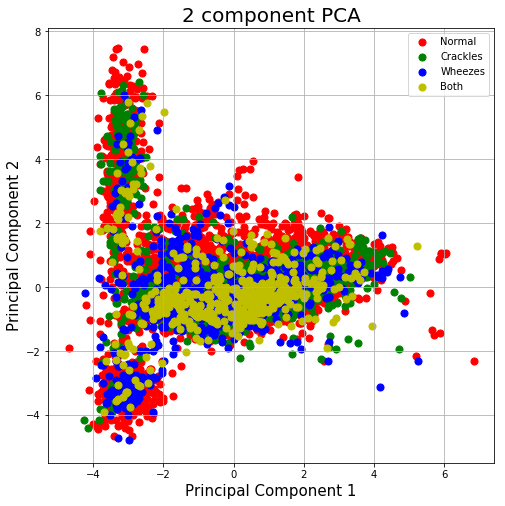

In [310]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Normal', 'Crackles', 'Wheezes', 'Both']
colors = ['r', 'g', 'b', 'y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
pca3 = PCA(n_components=3)
principalComponents3 = pca3.fit_transform(x_data)
principalDf3 = pd.DataFrame(data=principalComponents3,
                            columns=[
                                'principal component 1',
                                'principal component 2',
                                'principal component 3'
                            ])
finalDf = pd.concat([principalDf3, y_data], axis=1)

In [ ]:
import ipyvolume as ipv
fig = ipv.figure()
scatter = ipv.scatter(x, y, z, marker='box')
ipv.show()

## split data

In [118]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, ProgbarLogger
from keras.utils import np_utils
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import itertools
from sklearn.model_selection import train_test_split

In [386]:
def data_split(x_data, y_data):
    seed = 1000
    # split data into Train, Validation and Test
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                        y_data,
                                                        train_size=0.8,
                                                        random_state=seed,
                                                        shuffle=True)
    x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                      y_train,
                                                      train_size=0.8,
                                                      random_state=seed,
                                                      shuffle=True)

    # One-Hot encoding for classes
    y_train = np.array(keras.utils.to_categorical(y_train, 3))
    y_test = np.array(keras.utils.to_categorical(y_test, 3))
    y_val = np.array(keras.utils.to_categorical(y_val, 3))
    #test_y=np.array(keras.utils.to_categorical(test_y, 3))
    return x_train, x_test, x_val, y_train, y_test, y_val

In [442]:
x_train_crackles, x_test_crackles, x_val_crackles, y_train_crackles, y_test_crackles, y_val_crackles = data_split(crackles_feature_mfcc, crackles_label)
x_train_wheezes, x_test_wheezes, x_val_wheezes, y_train_wheezes, y_test_wheezes, y_val_wheezes = data_split(wheezes_feature_mfcc, wheezes_label)
#x_train_both, x_test_both, x_val_both, y_train_both, y_test_both, y_val_both = data_split(both_feature, both_label)
x_train_normal, x_test_normal, x_val_normal, y_train_normal, y_test_normal, y_val_normal = data_split(normal_feature_mfcc, normal_label)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [443]:
x_train = np.concatenate(
    (x_train_crackles, x_train_wheezes, x_train_both, x_train_normal), axis = 0)
x_test = np.concatenate(
    (x_test_crackles, x_test_wheezes, x_test_both, x_test_normal), axis = 0)
x_val = np.concatenate(
    (x_val_crackles, x_val_wheezes, x_val_both, x_val_normal), axis = 0)
y_train = np.concatenate(
    (y_train_crackles, y_train_wheezes, y_train_both, y_train_normal), axis = 0)
y_test = np.concatenate(
    (y_test_crackles, y_test_wheezes, y_test_both, y_test_normal), axis = 0)
y_val = np.concatenate(
    (y_val_crackles, y_val_wheezes, y_val_both, y_val_normal), axis = 0)
#print ("label shape: ", y_data.shape)
#print ("data size of the array: : %s" % y_data.size)
#print ("length of one array element in bytes: ", y_data.itemsize)
#print ("total bytes consumed by the elements of the array: ", y_data.nbytes)
#print (y_data[1])
#print ("")
#print ("audio data shape: ", x_data.shape)
#print ("data size of the array: : %s" % x_data.size)
#print ("length of one array element in bytes: ", x_data.itemsize)
#print ("total bytes consumed by the elements of the array: ", x_data.nbytes)
#print (x_data[1])
print ("")
print ("training data shape: ", x_train.shape)
print ("training label shape: ", y_train.shape)
print ("")
print ("validation data shape: ", x_val.shape)
print ("validation label shape: ", y_val.shape)
print ("")
print ("test data shape: ", x_test.shape)
print ("test label shape: ", y_test.shape)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [287]:
np.save('x_train.npy', x_train.reshape(4411, 128, 215, 1))
np.save('y_train.npy', y_train)
np.save('x_test.npy', x_test.reshape(1382, 128, 215, 1))
np.save('y_test.npy', y_test)
np.save('x_val.npy', x_val.reshape(1105, 128, 215, 1))
np.save('y_val.npy', y_val)


## Random forest

In [314]:
# The baseline predictions are the historical averages
baseline_preds = x_test[:, x_data.index('average')]
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - y_test)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [334]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators=200, random_state=42, max_features=3)
# Train the model on training data
rf.fit(x_train, y_train)

In [335]:
# Use the forest's predict method on the test data
predictions = rf.predict(x_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.16 degrees.


In [336]:
 predictions

array([[0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [338]:
y_test_nocat = [np.argmax(t) for t in y_test]
y_pred = [np.argmax(t) for t in predictions]
confusion_matrix(y_test_nocat, y_pred)

array([[687,  39,   3,   0],
       [232, 141,   0,   0],
       [148,   7,  23,   0],
       [ 94,   7,   0,   1]])

## Support vector machine

In [445]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
y_test_single = [np.argmax(t) for t in y_test]
y_train_single = [np.argmax(t) for t in y_train]
svc = svm.SVC(gamma="scale")

#Create a svm Classifier
clf = GridSearchCV(svc, param_grid, cv=5)
#Train the model using the training sets
clf.fit(x_train, y_train_single)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: Found array with dim 3. Estimator expected <= 2.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)

y_test_single = [np.argmax(t) for t in y_test]
y_train_single = [np.argmax(t) for t in y_train]

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(x_train, y_train_single)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()


In [ ]:
#Predict the response for test dataset
y_pred = clf.predict(x_test)

In [341]:
confusion_matrix(y_test_nocat, y_pred)

array([[729,   0,   0,   0],
       [373,   0,   0,   0],
       [178,   0,   0,   0],
       [102,   0,   0,   0]])

## build CNN model

In [533]:
y_train = np.load('y_train_noboth.npy')
y_val = np.load('y_val_noboth.npy')
y_test = np.load('y_test_noboth.npy')
x_train = np.load('x_train_noboth.npy')
x_val = np.load('x_val_noboth.npy')
x_test = np.load('x_test_noboth.npy')


In [524]:
x_val.shape

(1024, 60, 13)

In [534]:
x_train = x_train.reshape(4088, 60, 13, 1)
x_val = x_val.reshape(1024, 60, 13, 1)
x_test = x_test.reshape(1280, 60, 13, 1)

In [567]:
from keras import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Conv2D, Dense, Activation, Dropout, MaxPool2D, Flatten, LeakyReLU
import tensorflow as tf
K.clear_session()

model = Sequential()
model.add(Conv2D(128, [7,11], strides = [2,2], padding = 'SAME', input_shape = (60, 13, 1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(padding = 'SAME'))

model.add(Conv2D(256, [5,5], padding = 'SAME'))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(padding = 'SAME'))

model.add(Conv2D(256, [1,1], padding = 'SAME'))
model.add(Conv2D(256, [3,3], padding = 'SAME'))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(padding = 'SAME'))

model.add(Conv2D(512, [1,1], padding = 'SAME'))
model.add(Conv2D(512, [3,3], padding = 'SAME', activation = 'relu'))
model.add(MaxPool2D(padding = 'SAME'))
model.add(Flatten())

model.add(Dropout(0.5))

model.add(Dense(512, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

opt = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)

model.compile(optimizer =  opt , loss = 'categorical_crossentropy', metrics = ['acc'])

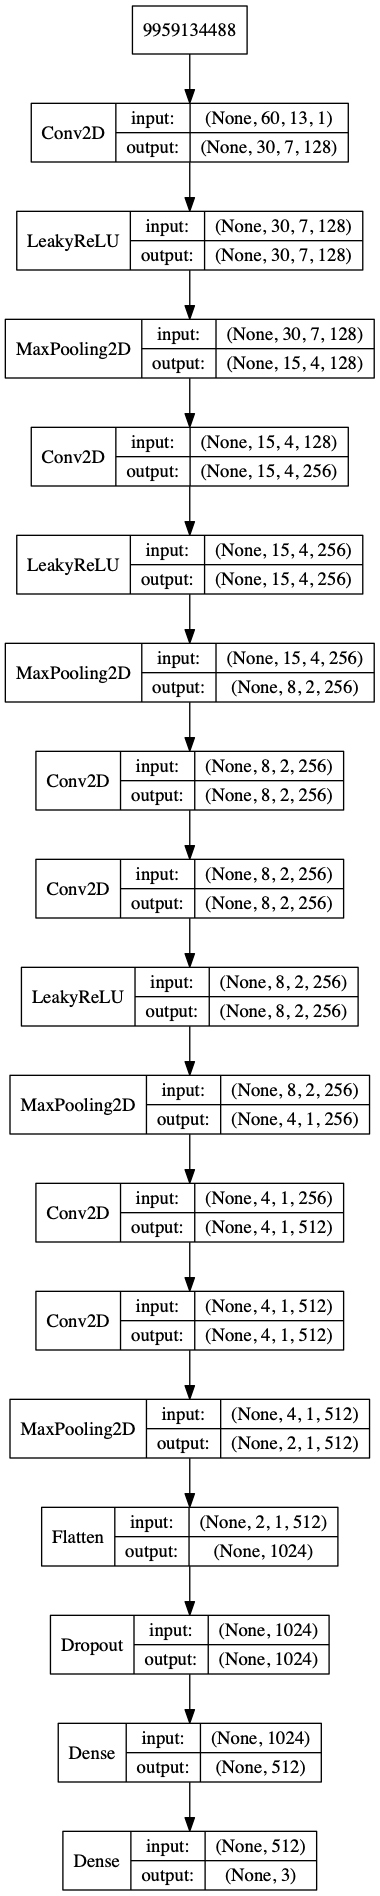

In [576]:
from keras.utils.vis_utils import plot_model
plot_model(model,  to_file='model_plot_cnn.png', show_shapes=True, show_layer_names = False)
#plt.show()
from IPython.display import Image
Image(filename='model_plot_cnn.png')

In [564]:
keras.backend.clear_session()

### train CNN model

In [568]:
%%time

# saved model checkpoint file
best_model_file = "./best_model_abnormal_sounds_cnn.hdf5"
#train_model_file=file_path+"/checkpoints/weights.best_{epoch:02d}-{loss:.2f}.hdf5"
MAX_PATIENT = 12
MAX_EPOCHS = 40
MAX_BATCH = 32

# callbacks
# removed EarlyStopping(patience=MAX_PATIENT)
callback = [
    ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
    ModelCheckpoint(filepath=best_model_file,
                    monitor='loss',
                    verbose=1,
                    save_best_only=True)
]

print("training started..... please wait.")
# training
history = model.fit(x_train,
                    y_train,
                    class_weight={
                        0: 1.755,
                        1: 3.429,
                        2: 7.214
                    },
                    batch_size=MAX_BATCH,
                    epochs=MAX_EPOCHS,
                    verbose=0,
                    validation_data=(x_val, y_val),
                    callbacks=callback)

print("training finised!")

training started..... please wait.

Epoch 00001: loss improved from inf to 3.55884, saving model to ./best_model_abnormal_sounds_cnn.hdf5

Epoch 00002: loss improved from 3.55884 to 3.09600, saving model to ./best_model_abnormal_sounds_cnn.hdf5

Epoch 00003: loss improved from 3.09600 to 3.00554, saving model to ./best_model_abnormal_sounds_cnn.hdf5

Epoch 00004: loss improved from 3.00554 to 2.86191, saving model to ./best_model_abnormal_sounds_cnn.hdf5

Epoch 00005: loss improved from 2.86191 to 2.79643, saving model to ./best_model_abnormal_sounds_cnn.hdf5

Epoch 00006: loss improved from 2.79643 to 2.64536, saving model to ./best_model_abnormal_sounds_cnn.hdf5

Epoch 00007: loss improved from 2.64536 to 2.54927, saving model to ./best_model_abnormal_sounds_cnn.hdf5

Epoch 00008: loss improved from 2.54927 to 2.38393, saving model to ./best_model_abnormal_sounds_cnn.hdf5

Epoch 00009: loss improved from 2.38393 to 2.25435, saving model to ./best_model_abnormal_sounds_cnn.hdf5

Epoch

<Figure size 1584x720 with 0 Axes>

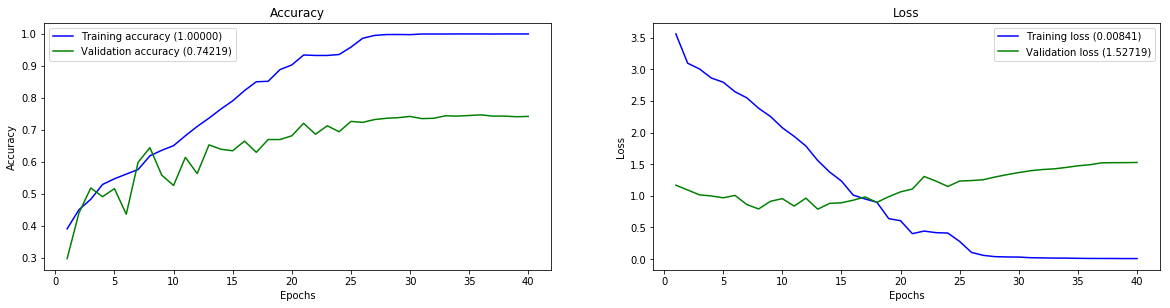

CPU times: user 1.67 s, sys: 173 ms, total: 1.85 s
Wall time: 1.76 s


In [569]:
%%time
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    plt.figure(figsize=(22,10))
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    ## Accuracy
    plt.figure(221, figsize=(20,10))
    ## Accuracy
    # plt.figure(2,figsize=(14,5))
    plt.subplot(221, title='Accuracy')
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    ## Loss
    plt.subplot(222, title='Loss')
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('LSTM_training_150_rep.png')
    plt.legend()
    plt.show()
# plot history
plot_history(history)

In [539]:
# Keras reported accuracy:
score = model.evaluate(x_train, y_train, verbose=0)
print("model train data score       : ", round(score[1] * 100), "%")

score = model.evaluate(x_test, y_test, verbose=0)
print("model test data score        : ", round(score[1] * 100), "%")

score = model.evaluate(x_val, y_val, verbose=0)
print("model validation data score  : ", round(score[1] * 100), "%")

#score = model.evaluate(test_x, test_y, verbose=0)
#print("model unlabeled data score   : ", round(score[1] * 100), "%")

model train data score       :  100.0 %
model test data score        :  72.0 %
model validation data score  :  71.0 %


In [540]:
# make a prediction
y_pred = model.predict_classes(x_test, batch_size=32)
#check scores
scores = model.evaluate(x_test, y_test, verbose=0)
print ("Model evaluation accuracy: ", round(scores[1]*100),"%")

y_test_nocat = [np.argmax(t) for t in y_test]
confusion_matrix(y_test_nocat, y_pred)

Model evaluation accuracy:  72.0 %


array([[587, 102,  40],
       [110, 252,  11],
       [ 82,  15,  81]])

In [542]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test_nocat, y_pred, target_names = ['normal','crackles','wheezes']))


              precision    recall  f1-score   support

      normal       0.75      0.81      0.78       729
    crackles       0.68      0.68      0.68       373
     wheezes       0.61      0.46      0.52       178

   micro avg       0.72      0.72      0.72      1280
   macro avg       0.68      0.65      0.66      1280
weighted avg       0.71      0.72      0.71      1280



## build LSTM model

In [2]:
keras.backend.clear_session()

In [2]:
keras.backend.clear_session()
print('Build LSTM RNN model ...')
model = Sequential()
model.add(
    LSTM(units=64,
         dropout=0.05,
         recurrent_dropout=0.20,
         return_sequences=True,
         input_shape=(50, 245)))
# model.add(
#     LSTM(units=32,
#          dropout=0.05,
#          recurrent_dropout=0.20,
#          return_sequences=True))
model.add(
    LSTM(units=32,
         dropout=0.05,
         recurrent_dropout=0.20,
         return_sequences=False))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='Adamax',
              metrics=['acc', 'mse', 'mae', 'mape', 'cosine'])
model.summary()

Build LSTM RNN model ...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 64)            79360     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 91,875
Trainable params: 91,875
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.load_weights('drlung/best_model_melspec_2lstmlayer_weighted.hdf5')

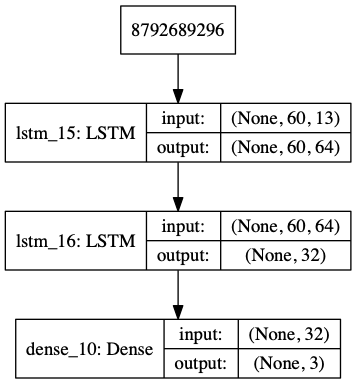

In [384]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image
plot_model(model, show_shapes=True, show_layer_names = True)
Image(filename='model.png')

### train LSTM model

In [6]:
x_train = np.load('x_train_melspec.npy')
y_train = np.load('y_train_melspec.npy')
x_test = np.load('x_test_melspec.npy')
y_test = np.load('y_test_melspec.npy')
x_val = np.load('x_val_melspec.npy')
y_val = np.load('y_val_melspec.npy')

ValueError: cannot reshape array of size 43724984 into shape (12395,50,245)

In [622]:
%%time
# saved model checkpoint file
best_model_file = "./best_model_abnormal_sounds_mfcc20.hdf5"
#train_model_file=file_path+"/checkpoints/weights.best_{epoch:02d}-{loss:.2f}.hdf5"
MAX_PATIENT = 12
MAX_EPOCHS = 150
MAX_BATCH = 32

# callbacks
# removed EarlyStopping(patience=MAX_PATIENT)
callback = [
    ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
    ModelCheckpoint(filepath=best_model_file,
                    monitor='loss',
                    verbose=1,
                    save_best_only=True)
]

print("training started..... please wait.")
# training
history = model.fit(x_train,
                    y_train,
                    class_weight={
                        0: 1.755,
                        1: 20,
                        2: 30
                    },
#                     class_weight={
#                         0: 1.755,
#                         1: 3.429,
#                         2: 7.214
#                     },
                    batch_size=MAX_BATCH,
                    epochs=MAX_EPOCHS,
                    verbose=0,
                    validation_data=(x_val, y_val),
                    callbacks=callback)

print("training finised!")

training started..... please wait.

Epoch 00001: loss improved from inf to 10.07914, saving model to ./best_model_abnormal_sounds_mfcc20.hdf5

Epoch 00002: loss improved from 10.07914 to 9.43549, saving model to ./best_model_abnormal_sounds_mfcc20.hdf5

Epoch 00003: loss improved from 9.43549 to 9.23587, saving model to ./best_model_abnormal_sounds_mfcc20.hdf5

Epoch 00004: loss improved from 9.23587 to 8.96124, saving model to ./best_model_abnormal_sounds_mfcc20.hdf5

Epoch 00005: loss did not improve from 8.96124

Epoch 00006: loss improved from 8.96124 to 8.94175, saving model to ./best_model_abnormal_sounds_mfcc20.hdf5

Epoch 00007: loss improved from 8.94175 to 8.79524, saving model to ./best_model_abnormal_sounds_mfcc20.hdf5

Epoch 00008: loss did not improve from 8.79524

Epoch 00009: loss improved from 8.79524 to 8.61777, saving model to ./best_model_abnormal_sounds_mfcc20.hdf5

Epoch 00010: loss did not improve from 8.61777

Epoch 00011: loss improved from 8.61777 to 8.57389, 

KeyboardInterrupt: 

In [623]:
#Plot Keras History
#Plot loss and accuracy for the training and validation set.
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    plt.figure(figsize=(22,10))
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    ## Accuracy
    plt.figure(221, figsize=(20,10))
    ## Accuracy
    # plt.figure(2,figsize=(14,5))
    plt.subplot(221, title='Accuracy')
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    ## Loss
    plt.subplot(222, title='Loss')
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('LSTM_training_mfcc20.png')
    plt.legend()
    plt.show()
    

<Figure size 1584x720 with 0 Axes>

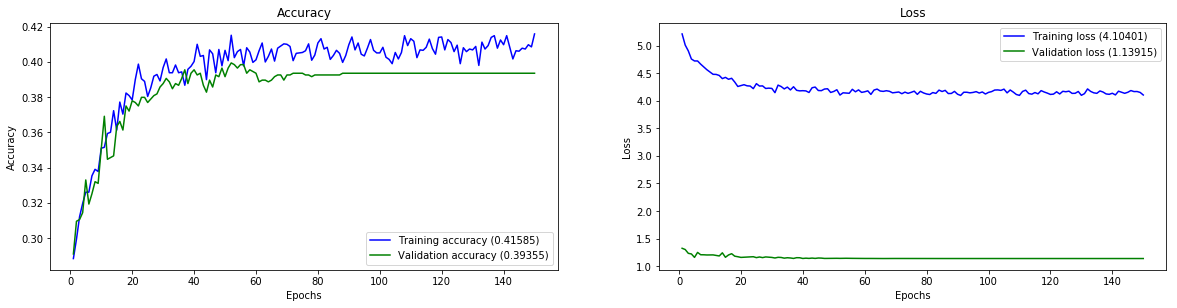

CPU times: user 1.56 s, sys: 245 ms, total: 1.81 s
Wall time: 1.76 s


In [624]:
%%time
# plot history
plot_history(history)

### Performance on testing data set

In [625]:
# Keras reported accuracy:
score = model.evaluate(x_train, y_train, verbose=0)
print("model train data score       : ", round(score[1] * 100), "%")

score = model.evaluate(x_test, y_test, verbose=0)
print("model test data score        : ", round(score[1] * 100), "%")

score = model.evaluate(x_val, y_val, verbose=0)
print("model validation data score  : ", round(score[1] * 100), "%")

#score = model.evaluate(test_x, test_y, verbose=0)
#print("model unlabeled data score   : ", round(score[1] * 100), "%")

model train data score       :  39.0 %
model test data score        :  34.0 %
model validation data score  :  34.0 %


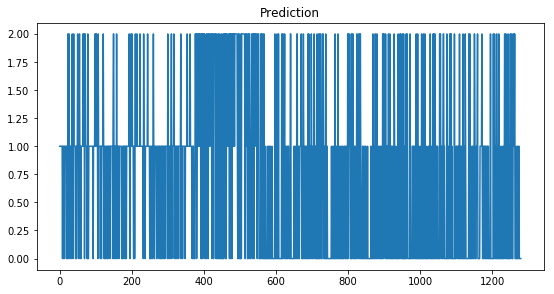

In [615]:
plt.figure(1,figsize=(20,10))
# plot Classification Metrics: Accuracy 
plt.subplot(221, title='Prediction')
plt.plot(y_pred)
plt.show()

In [626]:
### Loading a Check-Pointed Neural Network Model
# How to load and use weights from a checkpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# create model
print('Build LSTM RNN model ...')
model = Sequential()
model.add(
    LSTM(units=64,
         dropout=0.05,
         recurrent_dropout=0.35,
         return_sequences=True,
         input_shape=(60, 13)))
model.add(
    LSTM(units=32,
         dropout=0.05,
         recurrent_dropout=0.35,
         return_sequences=False))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc', 'mse', 'mae', 'mape', 'cosine'])
model.summary()
# load weights
model.load_weights(best_model_file)
# Compile model (required to make predictions)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print("Created model and loaded weights from file")

Build LSTM RNN model ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60, 64)            19968     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 32,483
Trainable params: 32,483
Non-trainable params: 0
_________________________________________________________________
Created model and loaded weights from file


In [577]:
from keras.models import load_model
model = load_model('best_model_abnormal_sounds_150.hdf5')

In [627]:
# make a prediction
y_pred = model.predict_classes(x_test, batch_size=32)
y_pred_probability = model.predict(x_test, batch_size=32)
#check scores
scores = model.evaluate(x_test, y_test, verbose=0)
print ("Model evaluation accuracy: ", round(scores[1]*100),"%")

y_test_nocat = [np.argmax(t) for t in y_test]
confusion_matrix(y_test_nocat, y_pred)

Model evaluation accuracy:  58.0 %


array([[  6, 437, 286],
       [  0, 319,  54],
       [  0,  76, 102]])

In [618]:
from sklearn.metrics import classification_report, confusion_matrix
y_test_nocat = [np.argmax(t) for t in y_test]
print(classification_report(y_test_nocat, y_pred, target_names = ['normal','crackles','wheezes']))
print(confusion_matrix(y_test_nocat, y_pred))

              precision    recall  f1-score   support

      normal       0.82      0.14      0.23       729
    crackles       0.39      0.88      0.54       373
     wheezes       0.29      0.49      0.36       178

   micro avg       0.40      0.40      0.40      1280
   macro avg       0.50      0.50      0.38      1280
weighted avg       0.62      0.40      0.34      1280

[[ 99 442 188]
 [ 14 330  29]
 [  7  84  87]]
